In [1]:
%load_ext autoreload
%autoreload 2

In [477]:
from collections import Counter
import glob
import os
import pickle
import re

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.models.ldamulticore import LdaMulticore
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

NOTEBOOKS_DIR = os.path.abspath(os.getcwd())
ROOT_DIR = os.path.split(NOTEBOOKS_DIR)[0]
PROCESSED_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'processed')

FINAL_DF_FILEPATH = os.path.join(PROCESSED_DATA_DIR, 'final.csv')

# Read in data

In [3]:
df = pd.read_csv(FINAL_DF_FILEPATH, encoding='utf-8')

# Subset out certain fields of data

In [4]:
df_cs = df[df['set_spec'] == 'cs']
df_math = df[df['set_spec'] == 'math']

# Basic description of data

In [5]:
df.shape

(1603370, 8)

In [6]:
df.columns

Index(['identifier', 'url', 'title', 'set_spec', 'subjects', 'authors',
       'dates', 'description'],
      dtype='object')

In [36]:
df.head()

,identifier,url,title,set_spec,subjects,authors,dates,description
0,oai:arXiv.org:1311.5328,http://arxiv.org/abs/1311.5328,Quenched invariance principle for a long-range...,math,"Mathematics - Probability,Primary 60K37, 60F17...","Zhongyang, Zhang,Li-Xin, Zhang","2013-11-21,2016-05-17",We consider a random walk on a random graph ...
1,oai:arXiv.org:1311.5329,http://arxiv.org/abs/1311.5329,Remarks on the energy release rate for an anti...,math,Mathematical Physics,"Morini, L.,Piccolroaz, A.,Mishuris, G.","2013-11-21,2014-04-10",This paper is concerned with the steady-stat...
2,oai:arXiv.org:1311.5330,http://arxiv.org/abs/1311.5330,Color spin wave functions of heavy tetraquark ...,physics:nucl-th,Nuclear Theory,"Park, Woosung,Lee, Su Houng",2013-11-21,"Using the variational method, we calculate t..."
3,oai:arXiv.org:1311.5331,http://arxiv.org/abs/1311.5331,"Stability, Electronic and Magnetic properties ...",physics:cond-mat,Condensed Matter - Materials Science,"Zhang, Jian-Min,Ming, Wenmei,Huang, Zhigao,Liu...",2013-11-21,Magnetic interaction with the gapless surfac...
4,oai:arXiv.org:1311.5332,http://arxiv.org/abs/1311.5332,"On a Conjecture of Erd\H{o}s, Gallai, and Tuza",math,"Mathematics - Combinatorics,05C70","Puleo, Gregory J.","2013-11-21,2014-10-13","Erd\H{o}s, Gallai, and Tuza posed the follow..."


## Papers by macro-subject

In [14]:
subject_counts = df['set_spec'].value_counts()
subject_counts

math                376287
physics:cond-mat    259489
physics:astro-ph    259231
cs                  236782
physics:hep-ph       94622
physics:physics      87542
physics:hep-th       54002
physics:quant-ph     50359
physics:gr-qc        46089
physics:hep-ex       36609
physics:hep-lat      18343
physics:nucl-th      17738
stat                 14555
nlin                 12850
q-bio                11678
physics:nucl-ex      10639
physics:nlin          7507
q-fin                 4352
eess                  3421
econ                  1275
Name: set_spec, dtype: int64

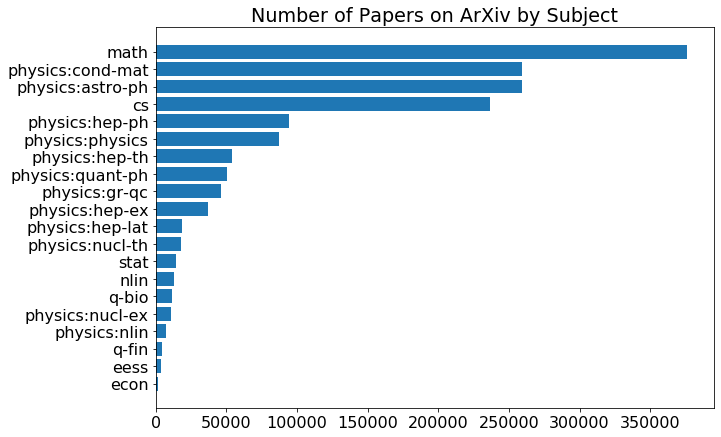

In [35]:
plt.figure(figsize=(10, 7))
_ = plt.barh(subject_counts.index[::-1], subject_counts.values[::-1])
_ = plt.title("Number of Papers on ArXiv by Subject")

In [84]:
subject_counts_df = pd.DataFrame(subject_counts).reset_index()
subject_counts_df.columns = ['subject', 'count']

In [87]:
subject_counts_df['subject_macro'] = subject_counts_df['subject'].apply(lambda x: 'physics' if 'physics' in x else x)
subject_counts_df

,subject,count,subject_macro
0,math,376287,math
1,physics:cond-mat,259489,physics
2,physics:astro-ph,259231,physics
3,cs,236782,cs
4,physics:hep-ph,94622,physics
5,physics:physics,87542,physics
6,physics:hep-th,54002,physics
7,physics:quant-ph,50359,physics
8,physics:gr-qc,46089,physics
9,physics:hep-ex,36609,physics


In [91]:
subject_counts_df = subject_counts_df.groupby('subject_macro').sum().reset_index()
subject_counts_df.sort_values('count', ascending=False, inplace=True)

In [92]:
subject_counts_df

,subject_macro,count
5,physics,942170
3,math,376287
0,cs,236782
8,stat,14555
4,nlin,12850
6,q-bio,11678
7,q-fin,4352
2,eess,3421
1,econ,1275


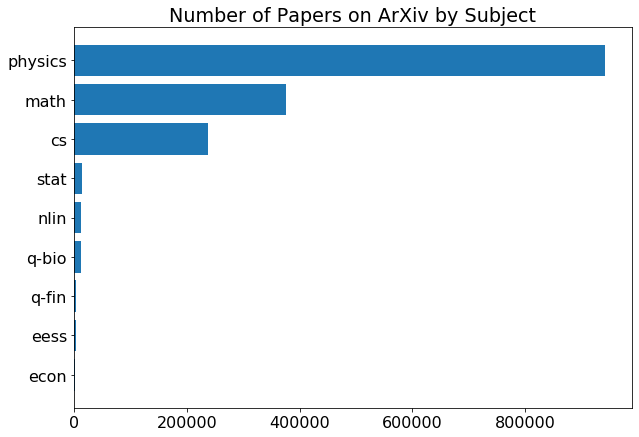

In [93]:
plt.figure(figsize=(10, 7))
_ = plt.barh(subject_counts_df['subject_macro'][::-1], subject_counts_df['count'][::-1])
_ = plt.title("Number of Papers on ArXiv by Subject")

### How many papers do we have if we exclude physics?

In [97]:
df['set_macro'] = df['set_spec'].apply(lambda x: 'physics' if 'physics' in x else x)
df_not_physics = df[df['set_macro'] != 'physics']

In [98]:
df_not_physics.shape

(661200, 9)

In [99]:
df_not_physics['set_macro'].value_counts()

math     376287
cs       236782
stat      14555
nlin      12850
q-bio     11678
q-fin      4352
eess       3421
econ       1275
Name: set_macro, dtype: int64

## Number of machine learning papers

In [39]:
machine_learning_subjects = df[df['subjects'].str.lower().str.contains('machine learning')]['subjects']
ml_subject_counts = Counter([item for x in machine_learning_subjects.values for item in x.split(',')])
ml_subject_counts_most_common_20 = ml_subject_counts.most_common(20)
ml_subject_counts_most_common_20

[('Computer Science - Machine Learning', 41875),
 ('Statistics - Machine Learning', 31114),
 ('Computer Science - Computer Vision and Pattern Recognition', 7092),
 ('Computer Science - Artificial Intelligence', 6945),
 ('Computer Science - Computation and Language', 3550),
 ('Computer Science - Neural and Evolutionary Computing', 2963),
 ('Mathematics - Optimization and Control', 2457),
 ('Computer Science - Information Theory', 1757),
 ('Mathematics - Statistics Theory', 1744),
 ('Computer Science - Information Retrieval', 1662),
 ('Statistics - Methodology', 1617),
 ('Computer Science - Cryptography and Security', 1464),
 ('Computer Science - Robotics', 1323),
 ('Computer Science - Social and Information Networks', 1198),
 ('Computer Science - Data Structures and Algorithms', 1179),
 ('Computer Science - Sound', 1143),
 ('Statistics - Applications', 1117),
 ('Statistics - Computation', 962),
 ('Electrical Engineering and Systems Science - Audio and Speech Processing',
  901),
 ('Elec

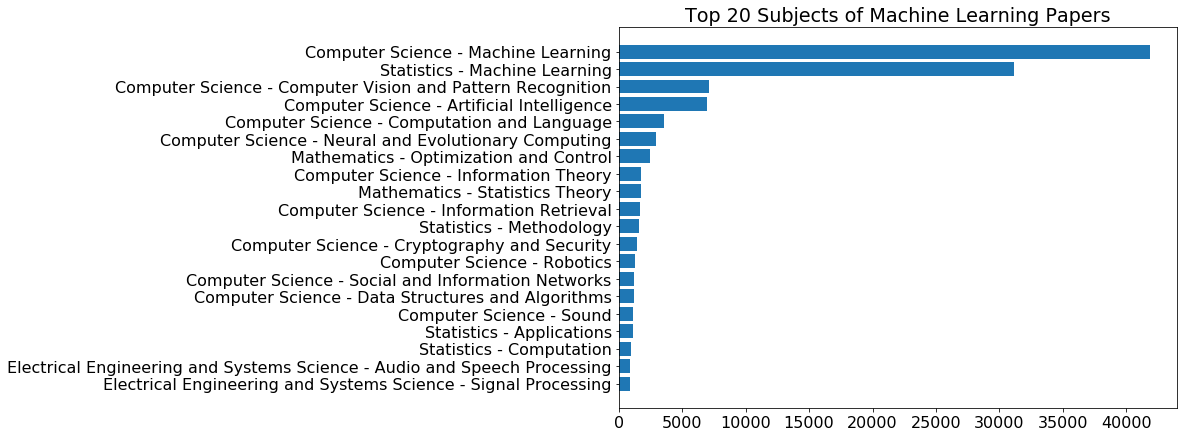

In [42]:
plt.figure(figsize=(10, 7))
subjects = [x[0] for x in ml_subject_counts_most_common_20]
counts = [x[1] for x in ml_subject_counts_most_common_20]
_ = plt.barh(subjects[::-1], counts[::-1])
_ = plt.title("Top 20 Subjects of Machine Learning Papers")

In [104]:
df_ml = df[df['subjects'].str.lower().str.contains('machine learning')]

### Percentage of papers that have "machine learning" in the subject

In [105]:
print(f'Full DataFrame -- {df.shape} -- {df.shape[0] * 100 / df.shape[0]:.0f}%')
print(f'ML DataFrame -- {df_ml.shape} -- {df_ml.shape[0] * 100 / df.shape[0]:.0f}%')

Full DataFrame -- (1603370, 9) -- 100%
ML DataFrame -- (48564, 9) -- 3%


## Number of papers by subject, for all subjects

In [58]:
all_subjects = df['subjects']
all_subject_counts = Counter([item for x in all_subjects.values for item in x.split(',')])

In [59]:
all_subject_counts.most_common(100)

[('High Energy Physics - Phenomenology', 145685),
 ('High Energy Physics - Theory', 132438),
 ('Astrophysics', 105380),
 ('Quantum Physics', 98237),
 ('General Relativity and Quantum Cosmology', 78539),
 ('Condensed Matter - Mesoscale and Nanoscale Physics', 64493),
 ('Condensed Matter - Materials Science', 60343),
 ('Mathematical Physics', 58774),
 ('Condensed Matter - Statistical Mechanics', 56298),
 ('Condensed Matter - Strongly Correlated Electrons', 54021),
 ('Astrophysics - Cosmology and Nongalactic Astrophysics', 48691),
 ('Nuclear Theory', 45522),
 ('Mathematics - Combinatorics', 42080),
 ('Computer Science - Machine Learning', 41875),
 ('Astrophysics - Solar and Stellar Astrophysics', 40061),
 ('High Energy Physics - Experiment', 39846),
 ('Astrophysics - Astrophysics of Galaxies', 38122),
 ('Mathematics - Algebraic Geometry', 38086),
 ('Mathematics - Analysis of PDEs', 37941),
 ('Mathematics - Probability', 37307),
 ('Astrophysics - High Energy Astrophysical Phenomena', 35453

In [60]:
df[df['subjects'].str.lower().str.contains('deep learning')]['subjects']

Series([], Name: subjects, dtype: object)

In [63]:
# Number of subjects
len(all_subject_counts.keys())

55527

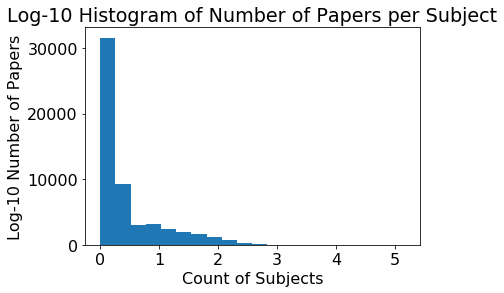

In [79]:
# Distribution of papers by subject
_ = plt.hist(np.log10(list(all_subject_counts.values())), bins=20)
_ = plt.title("Log-10 Histogram of Number of Papers per Subject")
_ = plt.ylabel("Log-10 Number of Papers")
_ = plt.xlabel("Count of Subjects")

# Number of authors for machine learning papers
Hmm—well it looks like I screwed myself a bit since I joined the authors to each other with commas. I'll come back and deal with that after I've made some progress with topic modeling. Basically I would just need to rewrite the data processing script and then re-run everything, which would just take a few minutes.

In [132]:
re.split(r'\w,', df_ml.head()['authors'].values[0])

['Rojo-Álvare',
 ' José Lui',
 'Martínez-Ramó',
 ' Mane',
 'Muñoz-Mar',
 ' Jord',
 'Camps-Vall',
 ' Gustavo']

In [114]:
df_ml.head()['authors'].values[0]

'Rojo-Álvarez, José Luis,Martínez-Ramón, Manel,Muñoz-Marí, Jordi,Camps-Valls, Gustavo'

In [113]:
list(map(str.strip, df_ml.head()['authors'].values[0].split(',')))

['Rojo-Álvarez',
 'José Luis',
 'Martínez-Ramón',
 'Manel',
 'Muñoz-Marí',
 'Jordi',
 'Camps-Valls',
 'Gustavo']

In [119]:
ml_authors = []
for row in df_ml['authors'].values:
    authors = list(map(str.strip, row.split(',')))
    ml_authors.extend(authors)

ml_author_counts = Counter(ml_authors)

In [121]:
ml_author_counts.most_common(100)

[('Wang', 3434),
 ('Zhang', 3043),
 ('Li', 3026),
 ('Chen', 2321),
 ('Liu', 2284),
 ('Yang', 1679),
 ('David', 1271),
 ('Xu', 1238),
 ('Yu', 1113),
 ('Wu', 1111),
 ('Lee', 975),
 ('Michael', 922),
 ('Huang', 904),
 ('Zhou', 901),
 ('Zhao', 845),
 ('Daniel', 836),
 ('Lin', 830),
 ('Zhu', 828),
 ('Wei', 769),
 ('Sun', 711),
 ('Kim', 692),
 ('Thomas', 622),
 ('Peter', 609),
 ('Lu', 603),
 ('Alexander', 572),
 ('Ma', 565),
 ('Song', 556),
 ('He', 534),
 ('Martin', 532),
 ('Cheng', 527),
 ('Han', 522),
 ('John', 513),
 ('Zheng', 513),
 ('Hu', 498),
 ('Yan', 490),
 ('Liang', 471),
 ('James', 465),
 ('Tang', 450),
 ('Nicolas', 439),
 ('Jun', 432),
 ('Gao', 429),
 ('Yuan', 423),
 ('Jiang', 422),
 ('Robert', 419),
 ('Andreas', 408),
 ('Yi', 407),
 ('Guo', 398),
 ('Peng', 392),
 ('Nguyen', 391),
 ('Chang', 388),
 ('Bo', 386),
 ('Shen', 382),
 ('Singh', 377),
 ('Marco', 377),
 ('Hao', 375),
 ('Andrew', 373),
 ('Paul', 372),
 ('Shi', 371),
 ('Xiao', 365),
 ('Lei', 361),
 ('Stefan', 357),
 ('Eric',

In [127]:
df_ml[df_ml['authors'].str.lower().str.contains('hinton')]['authors'].values[0]

'Kosiorek, Adam R.,Sabour, Sara,Teh, Yee Whye,Hinton, Geoffrey E.'

# Number of machine learning papers over time
For now, let's just consider the first date that's listed.

In [137]:
df_ml.head()['dates']

78                2013-11-21
94     2013-11-20,2013-11-21
151    2013-11-21,2013-11-22
224    2013-11-21,2014-09-08
271               2013-11-21
Name: dates, dtype: object

In [138]:
df_ml['first_date'] = df_ml['dates'].str.split(',').str[0]

/anaconda3/envs/capstone2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [140]:
df_ml.head()

,identifier,url,title,set_spec,subjects,authors,dates,description,set_macro,first_date
78,oai:arXiv.org:1311.5406,http://arxiv.org/abs/1311.5406,A Unified SVM Framework for Signal Estimation,stat,"Statistics - Machine Learning,Statistics - App...","Rojo-Álvarez, José Luis,Martínez-Ramón, Manel,...",2013-11-21,This paper presents a unified framework to t...,stat,2013-11-21
94,oai:arXiv.org:1311.5422,http://arxiv.org/abs/1311.5422,Sparse Overlapping Sets Lasso for Multitask Le...,cs,"Computer Science - Machine Learning,Statistics...","Rao, Nikhil,Cox, Christopher,Nowak, Robert,Rog...","2013-11-20,2013-11-21",Multitask learning can be effective when fea...,cs,2013-11-20
151,oai:arXiv.org:1311.5479,http://arxiv.org/abs/1311.5479,Learning Pairwise Graphical Models with Nonlin...,stat,Statistics - Machine Learning,"Yuan, Xiao-Tong,Li, Ping,Zhang, Tong","2013-11-21,2013-11-22",We investigate a generic problem of learning...,stat,2013-11-21
224,oai:arXiv.org:1311.5552,http://arxiv.org/abs/1311.5552,Bayesian Discovery of Threat Networks,cs,Computer Science - Social and Information Netw...,"Smith, Steven T.,Kao, Edward K.,Senne, Kenneth...","2013-11-21,2014-09-08",A novel unified Bayesian framework for netwo...,cs,2013-11-21
271,oai:arXiv.org:1311.5599,http://arxiv.org/abs/1311.5599,Compressive Measurement Designs for Estimating...,cs,"Statistics - Machine Learning,Computer Science...","Jain, Swayambhoo,Soni, Akshay,Haupt, Jarvis",2013-11-21,This work considers an estimation task in co...,cs,2013-11-21


In [164]:
date_col = 'first_date'
date_format='%Y-%m-%d'

date_series = pd.to_datetime(df_ml[date_col], format=date_format)
date_series.index = date_series
date_series[:] = 1

In [167]:
papers_per_week = date_series.resample('1W').size()
papers_per_month = date_series.resample('1M').size()
papers_per_year = date_series.resample('1Y').size()

In [168]:
papers_per_week

first_date
1997-12-14      1
1997-12-21      0
1997-12-28      0
1998-01-04      0
1998-01-11      0
             ... 
2019-09-15    458
2019-09-22    380
2019-09-29    469
2019-10-06    450
2019-10-13    379
Freq: W-SUN, Name: first_date, Length: 1140, dtype: int64

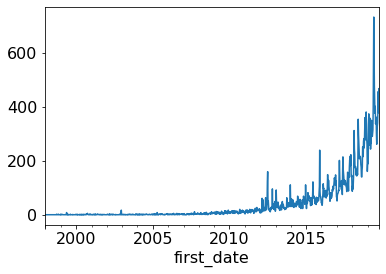

In [170]:
papers_per_week.plot()

In [202]:
def plot_counts_by_date(df, date_col, date_format='%Y-%m-%d', y_label='Count', figure_title=''):
    date_series = pd.to_datetime(df[date_col], format=date_format)
    date_series.index = date_series
    date_series[:] = 1

    papers_per_week = date_series.resample('1W').size()
    papers_per_month = date_series.resample('1M').size()
    papers_per_year = date_series.resample('1Y').size()

    fig, axs = plt.subplots(1, 3, figsize=(13, 5))
    axs = axs.flatten()
    title = fig.suptitle(figure_title)
    title.set_position([0.5, 1.1])

    papers_per_week.plot(ax=axs[0], title='By Week', legend=False)
    papers_per_month.plot(ax=axs[1], title='By Month', legend=False)
    papers_per_year.plot(ax=axs[2], title='By Year', legend=False)
    for ax in axs:
        ax.set_xlabel('')
    axs[0].set_ylabel(y_label)
    plt.tight_layout()
    plt.show()

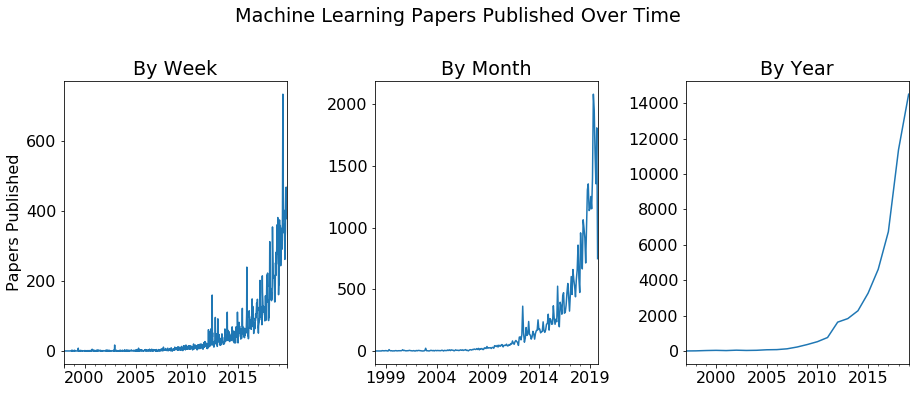

In [204]:
plot_counts_by_date(
    df_ml,
    date_col='first_date',
    y_label='Papers Published',
    figure_title='Machine Learning Papers Published Over Time'
)

In [544]:
df_ml['first_date'] = df_ml['dates'].str.split(',').str[0]
df_ml['year'] = df_ml['first_date'].map(lambda x: x.split('-')[0])

/anaconda3/envs/capstone2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/capstone2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [546]:
df_ml['year'].value_counts().sort_index()

1997        1
1998        7
1999       25
2000       36
2001       23
2002       45
2003       30
2004       39
2005       68
2006       77
2007      122
2008      224
2009      364
2010      525
2011      760
2012     1629
2013     1830
2014     2272
2015     3264
2016     4617
2017     6740
2018    11362
2019    14504
Name: year, dtype: int64

# Basic word count

In [205]:
pass

# Basic Topic Modeling - NMF
## Featurize the text

In [210]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

In [212]:
tfidf_ml = tfidf_vectorizer.fit_transform(df_ml['description'])

In [227]:
features = np.array(tfidf_vectorizer.get_feature_names())
features.shape

(60744,)

In [228]:
features[::1000]

array(['00', '2328', '624', 'acas', 'aidel', 'aot', 'attained', 'bch',
       'blistrtune', 'byzantinepgd', 'cep', 'clinic', 'compulsory',
       'cortical', 'cynthia', 'deepmind', 'dial', 'dmse', 'ease', 'encia',
       'evans', 'favourable', 'fonteneau', 'gasg21', 'gorrell', 'harden',
       'hongtengxu', 'ikdr', 'ininformation', 'irresistible',
       'kernelization', 'lawmakers', 'lmps', 'malformed', 'melodies',
       'misleading', 'mrmr', 'ncf', 'nongaussian', 'olcskei', 'ovis',
       'pends', 'playouts', 'prepared', 'publicizing', 'rarely',
       'reimplemention', 'rfid', 'rx', 'securely', 'sightings',
       'sonographer', 'starved', 'sugarcane', 'taml', 'tidying', 'trim',
       'underpasses', 'vacuous', 'vtn', 'worse'], dtype='<U65')

## Run NMF

In [218]:
nmf_model = NMF(n_components=10, random_state=42)

In [220]:
W = nmf_model.fit_transform(tfidf_ml)

In [223]:
W.shape

(48564, 10)

In [221]:
H = nmf_model.components_

In [224]:
H.shape

(10, 60744)

In [222]:
nmf_model.reconstruction_err_

214.64880467567292

In [238]:
def hand_label_topics(H, vocabulary):
    '''
    Print the most influential words of each latent topic, and prompt the user
    to label each topic. The user should use their humanness to figure out what
    each latent topic is capturing.
    '''
    hand_labels = []
    for i, row in enumerate(H):
        top_ten = np.argsort(row)[::-1][:10]
        print('topic', i)
        print('-->', ' '.join(vocabulary[top_ten]))
        label = input('please label this topic: ')
        hand_labels.append(label)
        print()
    return hand_labels

def print_influential_words_per_topic(H, vocabulary):
    '''
    Print the most influential words of each latent topic.
    '''
    hand_labels = []
    for i, row in enumerate(H):
        top_ten = np.argsort(row)[::-1][:10]
        print('topic', i)
        print('-->', ' '.join(vocabulary[top_ten]))
        print(H[i, top_ten])
        print()

In [239]:
print_influential_words_per_topic(H, features)

topic 0
--> data learning machine time real analysis methods series classification sets
[3.42728368 0.91277008 0.83532128 0.76814321 0.57162787 0.56180456
 0.55081958 0.54949722 0.48263448 0.47657914]

topic 1
--> optimization gradient convex matrix convergence stochastic problems method rank descent
[1.0687652  1.02994206 0.97256241 0.8057191  0.80124985 0.73425117
 0.6541769  0.6343447  0.59084966 0.57058573]

topic 2
--> neural networks network deep training layer convolutional layers architecture architectures
[1.8918856  1.83349385 1.81388113 1.2940825  0.72098239 0.60196585
 0.56018151 0.47429603 0.45948335 0.43142566]

topic 3
--> learning policy reinforcement agent rl agents control policies tasks reward
[1.64126279 1.21072374 0.98319234 0.75104212 0.61998511 0.50565936
 0.49893129 0.49017762 0.4519282  0.44605572]

topic 4
--> model models inference latent bayesian variational variables distribution gaussian posterior
[1.64899387 1.40214615 1.0670907  0.90237447 0.82564889 0.7

In [253]:
hand_label_topics(H, features)

topic 0
--> data learning machine time real analysis methods series classification sets
please label this topic: machine learning / time series

topic 1
--> optimization gradient convex matrix convergence stochastic problems method rank descent
please label this topic: optimization

topic 2
--> neural networks network deep training layer convolutional layers architecture architectures
please label this topic: neural networks / deep learning

topic 3
--> learning policy reinforcement agent rl agents control policies tasks reward
please label this topic: reinforcement learning

topic 4
--> model models inference latent bayesian variational variables distribution gaussian posterior
please label this topic: bayesian

topic 5
--> graph graphs node nodes embedding structure edges network embeddings spectral
please label this topic: graphs / graph ML

topic 6
--> adversarial attacks examples attack training robustness perturbations generative gan gans
please label this topic: Generative adver

['machine learning / time series',
 'optimization',
 'neural networks / deep learning',
 'reinforcement learning',
 'bayesian',
 'graphs / graph ML',
 'Generative adversarial networks',
 'image classification',
 'clustering',
 'optimal solutions']

These are the hand-labeled features for NMF with 10 topics.

In [254]:
hand_labeled_features = [
    'machine learning / time series',
    'optimization',
    'neural networks / deep learning',
    'reinforcement learning',
    'bayesian',
    'graphs / graph ML',
    'Generative adversarial networks',
    'image classification',
    'clustering',
    'optimal solutions'
]

In [237]:
H.shape

(10, 60744)

In [252]:
# These are the words with the highest summed loadings
features[np.argsort(np.sum(H, axis=0))[::-1][:30]]

array(['data', 'learning', 'graph', 'clustering', 'model', 'adversarial',
       'algorithm', 'networks', 'models', 'network', 'method', 'based',
       'training', 'neural', 'methods', 'deep', 'problem', 'algorithms',
       'proposed', 'approach', 'using', 'time', 'performance', 'results',
       'propose', 'paper', 'classification', 'new', 'machine', 'gradient'],
      dtype='<U65')

***************************************

***************************************

***************************************

***************************************

***************************************

***************************************

***************************************

***************************************

***************************************

***************************************

***************************************

***************************************


# BEFORE DOING ANYTHING ELSE, TAKE YOUR CODE AND CREATE A REPLICABLE PIPELINE OF WHAT YOU'VE ALREADY DONE

***************************************

***************************************

***************************************

***************************************

***************************************

***************************************

***************************************

***************************************

In [255]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_ml = tfidf_vectorizer.fit_transform(df_ml['description'])
features = np.array(tfidf_vectorizer.get_feature_names())
nmf_model = NMF(n_components=5, random_state=42)
W = nmf_model.fit_transform(tfidf_ml)
H = nmf_model.components_
print_influential_words_per_topic(H, features)

topic 0
--> data graph clustering classification method features feature methods learning based
[2.20272487 1.03417012 0.90207594 0.82866553 0.71518997 0.68470861
 0.68414143 0.68133929 0.65025357 0.60654654]

topic 1
--> algorithm optimization convex problem gradient algorithms convergence stochastic function matrix
[1.05968186 0.76030256 0.71075585 0.67757883 0.67336298 0.63586217
 0.61189922 0.58303915 0.58203558 0.56451713]

topic 2
--> neural networks network deep training adversarial image convolutional layer architecture
[1.53688163 1.5066287  1.48961655 1.13806293 0.95666282 0.76277574
 0.62550289 0.56064076 0.46580447 0.44248187]

topic 3
--> learning policy reinforcement agent rl tasks task agents control reward
[1.62210886 1.00906019 0.84467948 0.64849058 0.52430602 0.50703277
 0.44018067 0.43935982 0.43152674 0.42391304]

topic 4
--> model models inference latent bayesian variational distribution variables gaussian generative
[1.48042159 1.23794748 0.81725156 0.73685414 0.6

In [256]:
nmf_model.reconstruction_err_

215.97005812963866

In [257]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_ml = tfidf_vectorizer.fit_transform(df_ml['description'])
features = np.array(tfidf_vectorizer.get_feature_names())
nmf_model = NMF(n_components=3, random_state=42)
W = nmf_model.fit_transform(tfidf_ml)
H = nmf_model.components_
print_influential_words_per_topic(H, features)

topic 0
--> data model models graph method based approach clustering learning methods
[1.98390026 1.23273645 0.88910722 0.71596485 0.63444124 0.62798368
 0.61855309 0.61754799 0.61514768 0.59707703]

topic 1
--> algorithm optimization algorithms problem gradient function convex problems stochastic convergence
[1.10014634 0.7491107  0.7464176  0.70686733 0.65317382 0.63037223
 0.62926758 0.57959465 0.5778638  0.56679646]

topic 2
--> neural network networks deep training learning adversarial image tasks convolutional
[1.29845233 1.27462491 1.26579287 1.16605616 0.9152374  0.90679747
 0.64606511 0.61037877 0.51195842 0.47589232]



In [258]:
nmf_model.reconstruction_err_

216.63075630099303

In [259]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_ml = tfidf_vectorizer.fit_transform(df_ml['description'])
features = np.array(tfidf_vectorizer.get_feature_names())
nmf_model = NMF(n_components=2, random_state=42)
W = nmf_model.fit_transform(tfidf_ml)
H = nmf_model.components_
print_influential_words_per_topic(H, features)

topic 0
--> learning network model neural networks data deep training models classification
[1.18673949 1.03751625 1.03589466 0.99627381 0.97205692 0.95879843
 0.94503978 0.87601181 0.82589661 0.59094089]

topic 1
--> algorithm problem algorithms data optimization function method problems matrix gradient
[1.01150746 0.68987488 0.68098566 0.631806   0.58497795 0.52082087
 0.5113873  0.50745361 0.49040991 0.47894028]



In [260]:
nmf_model.reconstruction_err_

217.00284441706012

In [261]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_ml = tfidf_vectorizer.fit_transform(df_ml['description'])
features = np.array(tfidf_vectorizer.get_feature_names())
nmf_model = NMF(n_components=100, random_state=42)
W = nmf_model.fit_transform(tfidf_ml)
H = nmf_model.components_
print_influential_words_per_topic(H, features)

topic 0
--> data sets real missing synthetic big points world large mining
[92.76109988  8.36132146  8.15342866  5.92678318  5.86628064  4.74998429
  4.33378389  4.05762253  3.88551868  3.83571232]

topic 1
--> algorithm proposed em new efficient based means propose present step
[16.79391243  1.25406015  1.2177612   0.87266729  0.86530552  0.62136675
  0.60359606  0.54819894  0.5416872   0.52122048]

topic 2
--> networks neural convolutional recurrent activation relu artificial neurons complex architectures
[12.84411356  8.73038404  0.89569314  0.82748998  0.73351385  0.72313133
  0.60103141  0.5193114   0.49929754  0.49591706]

topic 3
--> learning machine reinforcement active meta learn techniques transfer approaches shot
[7.5124093  2.07866961 0.69285204 0.67507397 0.35016214 0.29230184
 0.20527257 0.20246896 0.19437918 0.18344252]

topic 4
--> models graphical generative probabilistic predictive modeling complex interpretable mixture likelihood
[12.98268463  0.86165425  0.75671764 

topic 77
--> class classes shot imbalance imbalanced unseen examples new minority instances
[4.32030128 1.97483883 0.4906721  0.3380921  0.31329261 0.26997994
 0.22420311 0.20643311 0.20068035 0.19876883]

topic 78
--> functions activation submodular relu continuous basis family monotone hash functional
[4.96331435 1.039826   0.90328542 0.34010762 0.31466113 0.21831856
 0.21248007 0.18671286 0.18399102 0.17525178]

topic 79
--> online batch offline regret setting adaptive streaming dynamic stream real
[4.6992315  0.57109399 0.52108498 0.50223687 0.43141124 0.32434494
 0.28055191 0.25446379 0.18411516 0.17893952]

topic 80
--> label labels active instance noisy labeling multi instances datasets labeled
[3.99492473 2.60108292 0.42458001 0.38580839 0.32401303 0.30749889
 0.30472133 0.29050272 0.22506139 0.19320165]

topic 81
--> sample samples complexity size number testing finite computational dimension tests
[2.90099649 1.53490419 1.48747226 0.73151555 0.3619714  0.33991886
 0.26092674 

In [262]:
nmf_model.reconstruction_err_

203.54948614185938

In [263]:
# Saving this specific model to another variable
nmf_model_100 = nmf_model

In [271]:
with open(os.path.join(ROOT_DIR, 'models', 'nmf_100.pkl'), 'wb') as f:
    pickle.dump(nmf_model_100, f)

# Training the model on the full corpus, but running it on specific years

In [292]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_ml = tfidf_vectorizer.fit_transform(df_ml['description'])
features = np.array(tfidf_vectorizer.get_feature_names())
nmf_model = NMF(n_components=10, random_state=42)
W = nmf_model.fit_transform(tfidf_ml)
H = nmf_model.components_
print_influential_words_per_topic(H, features)

topic 0
--> data learning machine time real analysis methods series classification sets
[3.42728368 0.91277008 0.83532128 0.76814321 0.57162787 0.56180456
 0.55081958 0.54949722 0.48263448 0.47657914]

topic 1
--> optimization gradient convex matrix convergence stochastic problems method rank descent
[1.0687652  1.02994206 0.97256241 0.8057191  0.80124985 0.73425117
 0.6541769  0.6343447  0.59084966 0.57058573]

topic 2
--> neural networks network deep training layer convolutional layers architecture architectures
[1.8918856  1.83349385 1.81388113 1.2940825  0.72098239 0.60196585
 0.56018151 0.47429603 0.45948335 0.43142566]

topic 3
--> learning policy reinforcement agent rl agents control policies tasks reward
[1.64126279 1.21072374 0.98319234 0.75104212 0.61998511 0.50565936
 0.49893129 0.49017762 0.4519282  0.44605572]

topic 4
--> model models inference latent bayesian variational variables distribution gaussian posterior
[1.64899387 1.40214615 1.0670907  0.90237447 0.82564889 0.7

In [293]:
df_ml_2000 = df_ml[df_ml['first_date'].str.split('-').str[0] == '2000']

In [294]:
df_ml_2000.shape

(36, 10)

In [295]:
tfidf_ml_2000 = tfidf_vectorizer.transform(df_ml_2000['description'])
features = np.array(tfidf_vectorizer.get_feature_names())
W = nmf_model.transform(tfidf_ml_2000)

In [296]:
tfidf_ml.shape

(48564, 60744)

In [297]:
tfidf_ml_2000.shape

(36, 60744)

In [304]:
np.mean(W, axis=0)

array([0.0111827 , 0.00397646, 0.00116574, 0.00937776, 0.00982136,
       0.00063196, 0.00119234, 0.00762975, 0.00372672, 0.01325408])

## Alright, let's try getting the mean topic loadings for each year since 2000...

In [307]:
mean_topic_loadings_by_year = {}
for year in range(2000, 2020):
    print(f'calculating for {year}')
    df_ml_year = df_ml[df_ml['first_date'].str.split('-').str[0] == str(year)]
    tfidf_ml_year = tfidf_vectorizer.transform(df_ml_year['description'])
    features = np.array(tfidf_vectorizer.get_feature_names())
    W = nmf_model.transform(tfidf_ml_year)
    mean_topic_loadings_by_year[year] = np.mean(W, axis=0)

calculating for 2000
calculating for 2001
calculating for 2002
calculating for 2003
calculating for 2004
calculating for 2005
calculating for 2006
calculating for 2007
calculating for 2008
calculating for 2009
calculating for 2010
calculating for 2011
calculating for 2012
calculating for 2013
calculating for 2014
calculating for 2015
calculating for 2016
calculating for 2017
calculating for 2018
calculating for 2019


In [308]:
mean_topic_loadings_by_year

{2000: array([0.0111827 , 0.00397646, 0.00116574, 0.00937776, 0.00982136,
        0.00063196, 0.00119234, 0.00762975, 0.00372672, 0.01325408]),
 2001: array([0.00549396, 0.00641427, 0.00070074, 0.01899635, 0.00529625,
        0.00319743, 0.00015604, 0.00767215, 0.00892845, 0.01306405]),
 2002: array([0.00963932, 0.00321659, 0.00084745, 0.01344216, 0.00367973,
        0.00100805, 0.00129181, 0.0124945 , 0.00289549, 0.01520761]),
 2003: array([0.00383465, 0.0045476 , 0.00257645, 0.01197142, 0.00816662,
        0.0020822 , 0.00037212, 0.00883554, 0.00208704, 0.01596193]),
 2004: array([0.00750946, 0.00561805, 0.00397014, 0.00931082, 0.00931979,
        0.00061518, 0.00066661, 0.00727606, 0.00255759, 0.01599484]),
 2005: array([0.00474845, 0.0041936 , 0.00472776, 0.00682605, 0.00976679,
        0.0012167 , 0.00156908, 0.00854192, 0.00141788, 0.02312815]),
 2006: array([0.00788257, 0.00762599, 0.00232945, 0.00867283, 0.00875335,
        0.00334531, 0.00126383, 0.00623213, 0.00231457, 0.0167

In [313]:
years = list(mean_topic_loadings_by_year.keys())
loadings = list(mean_topic_loadings_by_year.values())

No handles with labels found to put in legend.


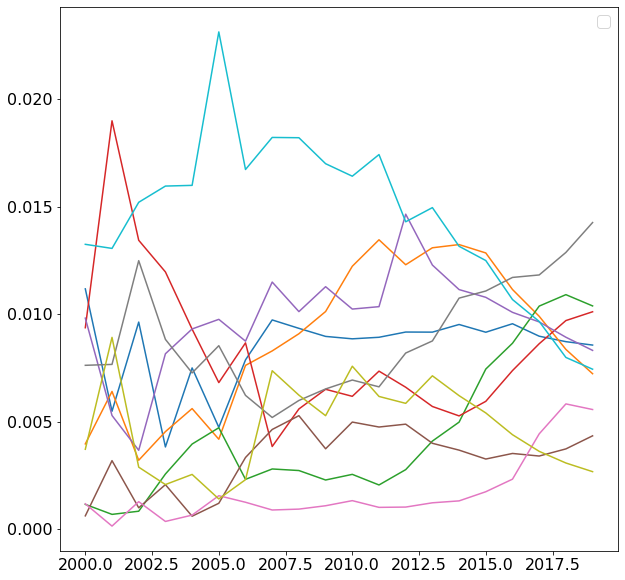

In [343]:
plt.figure(figsize=(10, 10))
_ = plt.plot(years, loadings)
_ = plt.legend()

In [328]:
years

[2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]

In [339]:
len(list(zip([list(x) for x in loadings])))

20

In [340]:
{f'y{i}': list(zip([list(x) for x in loadings]))[i] for i in range(20)}

{'y0': ([0.011182704509721116,
   0.0039764613749746925,
   0.0011657415087166503,
   0.009377759905633491,
   0.009821364667612529,
   0.0006319566581777868,
   0.0011923425404422405,
   0.007629754520791889,
   0.003726715926331498,
   0.01325407997732649],),
 'y1': ([0.0054939617450924,
   0.0064142694620329035,
   0.0007007385163983333,
   0.018996347679328035,
   0.005296254930654634,
   0.0031974260648660823,
   0.00015604163599048016,
   0.0076721460869285316,
   0.008928454316233875,
   0.013064054758243735],),
 'y2': ([0.009639320214052725,
   0.003216586779259181,
   0.0008474476601586391,
   0.013442160643780652,
   0.00367972755713343,
   0.0010080486311238705,
   0.0012918104215812627,
   0.012494499448376457,
   0.0028954895550872156,
   0.015207605370529184],),
 'y3': ([0.003834653890244539,
   0.004547600256011332,
   0.002576447121235289,
   0.011971419460432136,
   0.008166623765250163,
   0.0020821982492286698,
   0.00037212075646160075,
   0.008835543167910048,
   0

# If there were only three topics for each year, what would they be?

In [355]:
def get_year_df(df, date_col, year):
    year = str(year)
    return df[df[date_col].map(lambda x: x.split('-')[0]) == year]

def get_topics_for_year(df, num_topics=3):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_ml = tfidf_vectorizer.fit_transform(df['description'])
    features = np.array(tfidf_vectorizer.get_feature_names())
    nmf_model = NMF(n_components=num_topics, random_state=42)
    W = nmf_model.fit_transform(tfidf_ml)
    H = nmf_model.components_
    
    print_influential_words_per_topic(H, features)

# Three Topics: Each Year Between 2000 and 2019

In [366]:
df_ml['first_date'].map(lambda x: x.split('-')[0]).value_counts()

2019    14504
2018    11362
2017     6740
2016     4617
2015     3264
2014     2272
2013     1830
2012     1629
2011      760
2010      525
2009      364
2008      224
2007      122
2006       77
2005       68
2002       45
2004       39
2000       36
2003       30
1999       25
2001       23
1998        7
1997        1
Name: first_date, dtype: int64

In [361]:
for year in range(2000, 2020):
    df_ml_year = get_year_df(df_ml, 'first_date', year)
    print('*' * 20)
    print('*' * 7, str(year), '*' * 7)
    print('*' * 20)
    get_topics_for_year(df_ml_year)

********************
******* 2000 *******
********************
topic 0
--> data information learning fuzzy model systems noise complexity modeling theory
[0.33302551 0.31993993 0.29868442 0.27652818 0.23299953 0.21612866
 0.20114306 0.16313749 0.1607293  0.15739805]

topic 1
--> aixi formally problem universal tl solves distribution theory agent sequence
[0.51600951 0.24825374 0.23804046 0.21946434 0.21425019 0.21425019
 0.18393482 0.17493551 0.15544538 0.14581257]

topic 2
--> spam mail naive filters filter performance bayesian keyword anti patterns
[0.39554017 0.30687463 0.24794257 0.24794257 0.23293248 0.22234207
 0.21359527 0.20068994 0.19485023 0.14696528]

********************
******* 2001 *******
********************
topic 0
--> sentences corpus algorithm parts constituents ovis information et al atis
[0.72196587 0.49441515 0.33951997 0.28660285 0.21611222 0.20611689
 0.16716293 0.16469774 0.16469774 0.1598637 ]

topic 1
--> random study stable laws roots turn harmonic leads mat

topic 0
--> sparse problem algorithm optimization convex matrix problems function algorithms convergence
[0.46666368 0.45395241 0.45064274 0.39816496 0.3852373  0.37852828
 0.35467429 0.3205733  0.30834316 0.26853126]

topic 1
--> models model bayesian inference variables latent structure network networks data
[0.67192892 0.6531573  0.37841712 0.35650512 0.34575112 0.34095277
 0.2797342  0.25789212 0.24204248 0.22063057]

topic 2
--> data learning classification feature based clustering method features methods proposed
[0.5402084  0.48527839 0.34107961 0.315734   0.24948403 0.24169793
 0.24031792 0.23254467 0.23186498 0.22635566]

********************
******* 2013 *******
********************
topic 0
--> model models bayesian data inference variables parameters approach latent likelihood
[0.81115116 0.66688109 0.4633564  0.37890303 0.35716574 0.35385731
 0.33627572 0.32100138 0.29408    0.28692514]

topic 1
--> matrix algorithm problem sparse convex rank optimization bounds algorithms 

# If we get our topics for the full dataset and then look at the distribution of each topic over time, what does that look like? (Maybe starting with topic 0.)

In [367]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_ml = tfidf_vectorizer.fit_transform(df_ml['description'])
features = np.array(tfidf_vectorizer.get_feature_names())
nmf_model = NMF(n_components=10, random_state=42)
W = nmf_model.fit_transform(tfidf_ml)
H = nmf_model.components_
print_influential_words_per_topic(H, features)

topic 0
--> data learning machine time real analysis methods series classification sets
[3.42728368 0.91277008 0.83532128 0.76814321 0.57162787 0.56180456
 0.55081958 0.54949722 0.48263448 0.47657914]

topic 1
--> optimization gradient convex matrix convergence stochastic problems method rank descent
[1.0687652  1.02994206 0.97256241 0.8057191  0.80124985 0.73425117
 0.6541769  0.6343447  0.59084966 0.57058573]

topic 2
--> neural networks network deep training layer convolutional layers architecture architectures
[1.8918856  1.83349385 1.81388113 1.2940825  0.72098239 0.60196585
 0.56018151 0.47429603 0.45948335 0.43142566]

topic 3
--> learning policy reinforcement agent rl agents control policies tasks reward
[1.64126279 1.21072374 0.98319234 0.75104212 0.61998511 0.50565936
 0.49893129 0.49017762 0.4519282  0.44605572]

topic 4
--> model models inference latent bayesian variational variables distribution gaussian posterior
[1.64899387 1.40214615 1.0670907  0.90237447 0.82564889 0.7

In [368]:
W.shape

(48564, 10)

In [372]:
df_ml['year'] = df_ml['first_date'].map(lambda x: x.split('-')[0])

/anaconda3/envs/capstone2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [375]:
W[:, 0].shape

(48564,)

In [397]:
W_series = pd.Series(W[:, 0])
W_series.name = 'topic_loadings'
W_series = W_series.reset_index(drop=True)

years = df_ml['year']
years = years.reset_index(drop=True)

In [396]:
W_series

0        0.017501
1        0.012086
2        0.000000
3        0.005405
4        0.009112
           ...   
48559    0.004430
48560    0.002888
48561    0.012906
48562    0.005982
48563    0.000000
Name: topic_loadings, Length: 48564, dtype: float64

In [398]:
years

0        2013
1        2013
2        2013
3        2013
4        2013
         ... 
48559    2014
48560    2014
48561    2014
48562    2014
48563    2014
Name: year, Length: 48564, dtype: object

In [404]:
topic_0_over_time = pd.DataFrame()
topic_0_over_time['years'] = years
topic_0_over_time['topic_loadings'] = W_series

In [405]:
topic_0_over_time

,years,topic_loadings
0,2013,0.017501
1,2013,0.012086
2,2013,0.000000
3,2013,0.005405
4,2013,0.009112
...,...,...
48559,2014,0.004430
48560,2014,0.002888
48561,2014,0.012906
48562,2014,0.005982


In [434]:
years = df_ml['year']
years = years.reset_index(drop=True)

## Topic 0 Over Time - "machine learning / time series"

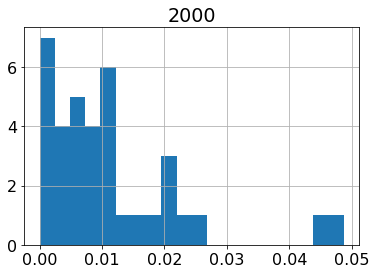

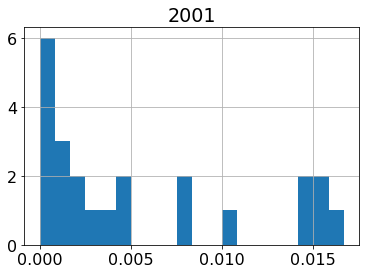

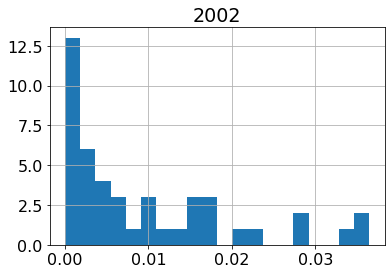

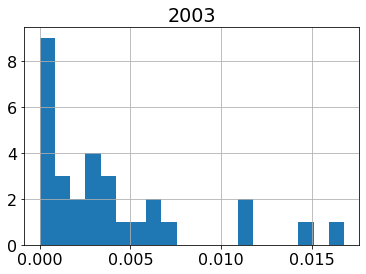

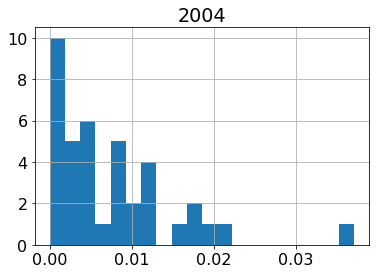

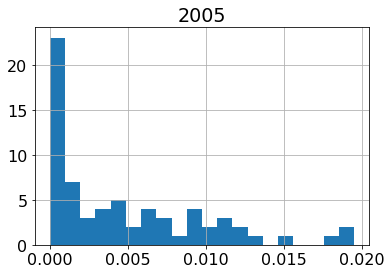

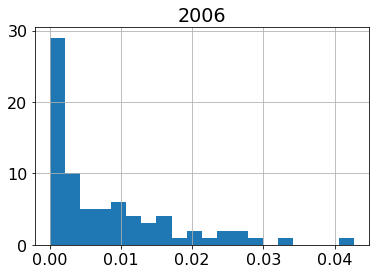

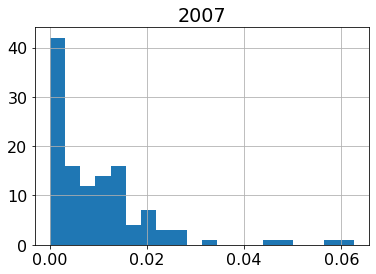

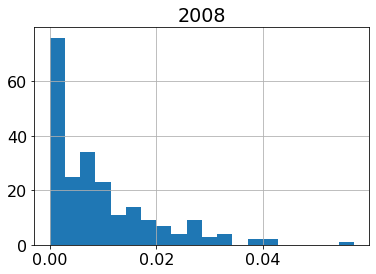

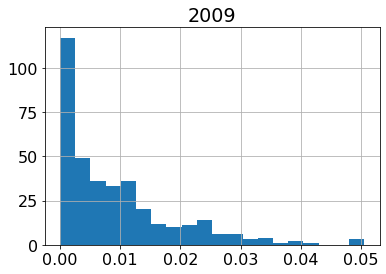

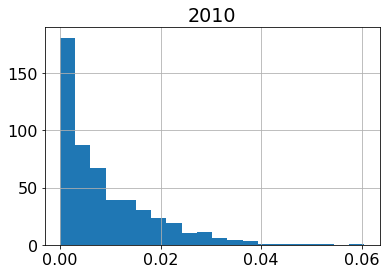

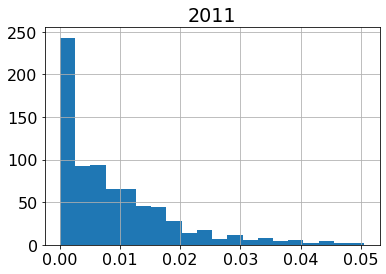

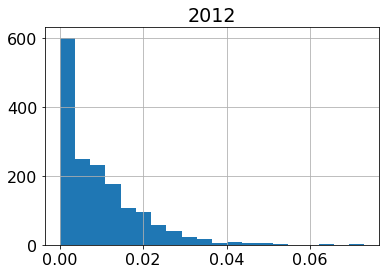

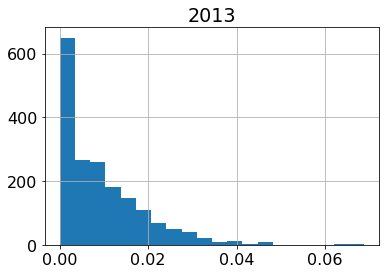

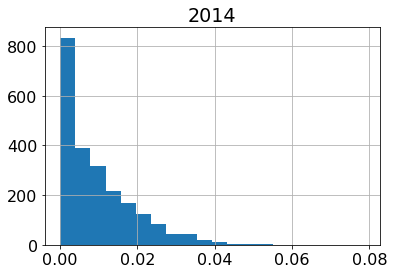

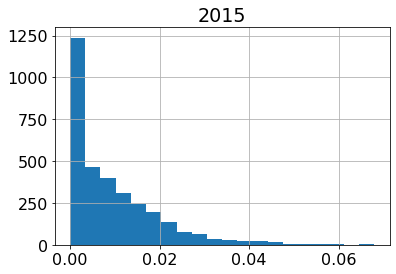

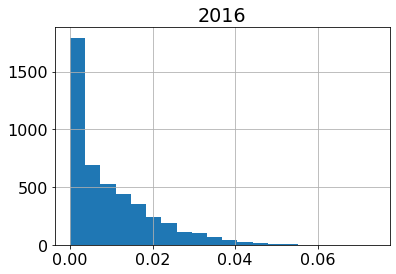

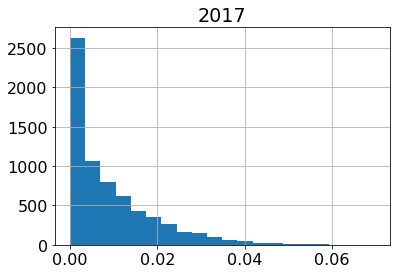

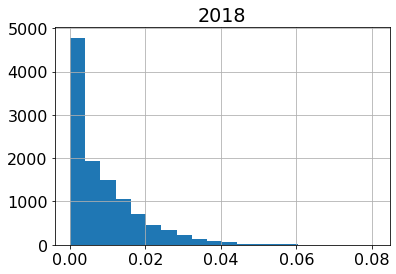

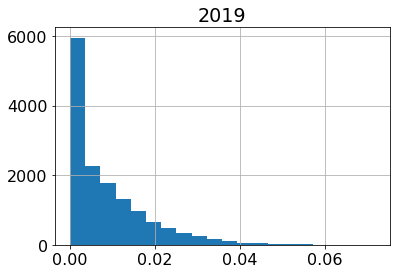

In [417]:
W_series = pd.Series(W[:, 0])
W_series.name = 'topic_loadings'
W_series = W_series.reset_index(drop=True)

for year in range(2000, 2020):
    W_series[years == str(year)].hist(bins=20)
    plt.title(str(year))
    plt.show()

## Topic 1 Over Time - "optimization"

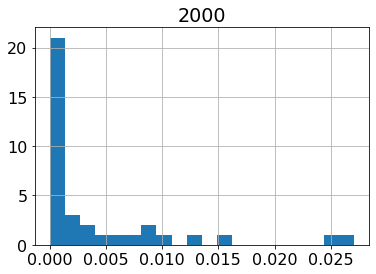

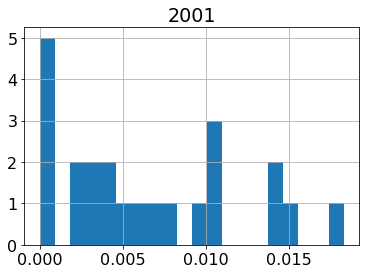

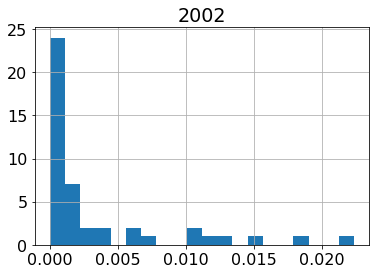

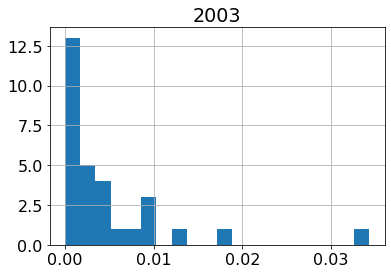

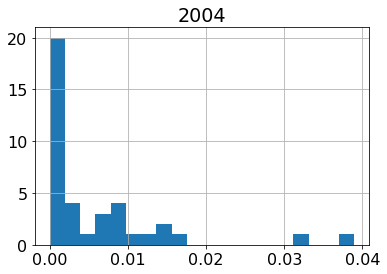

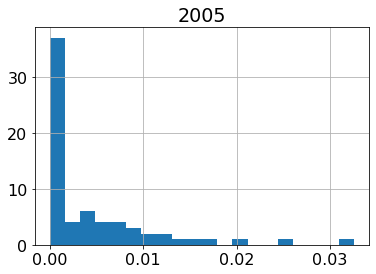

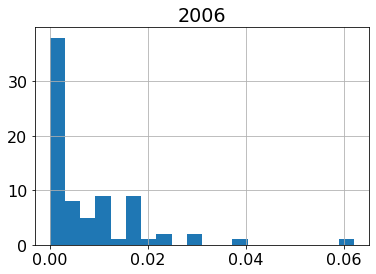

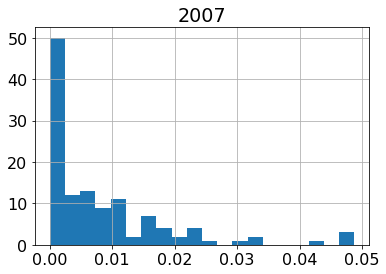

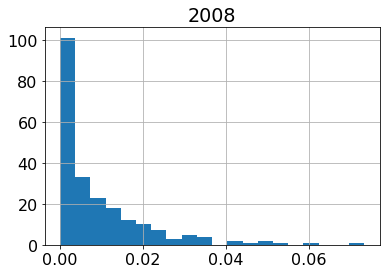

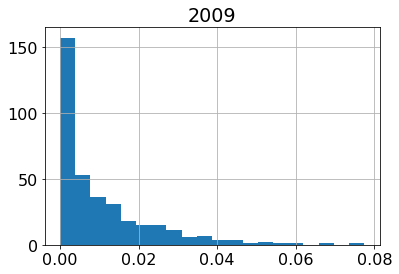

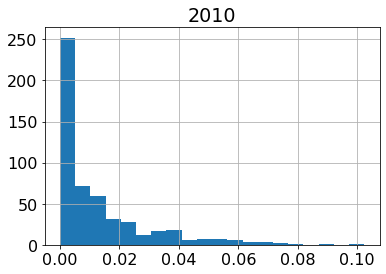

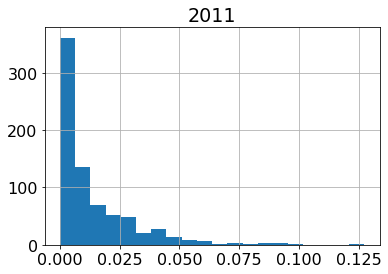

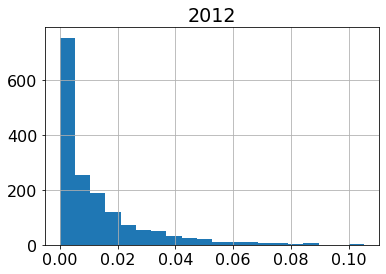

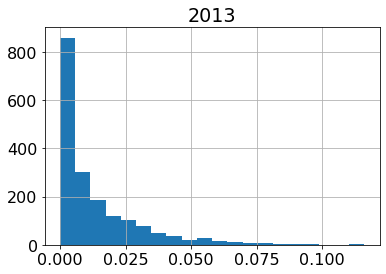

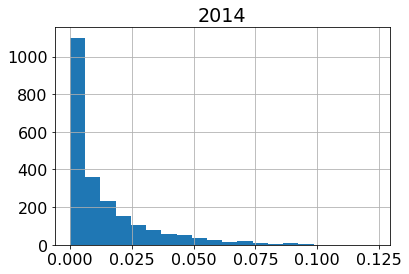

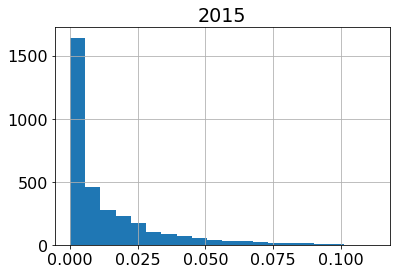

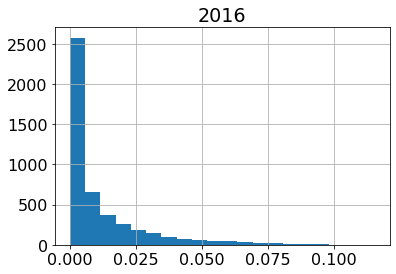

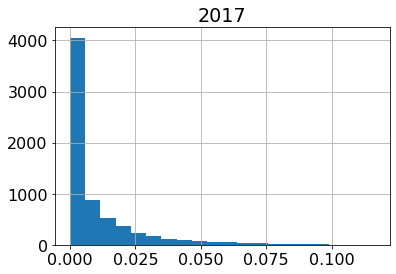

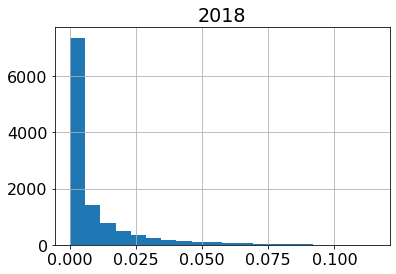

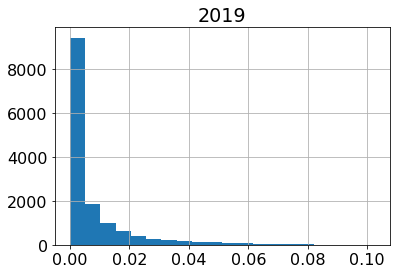

In [435]:
W_series = pd.Series(W[:, 1])
W_series.name = 'topic_loadings'
W_series = W_series.reset_index(drop=True)

for year in range(2000, 2020):
    W_series[years == str(year)].hist(bins=20)
    plt.title(str(year))
    plt.show()

## Topic 2 Over Time - "neural networks / deep learning"

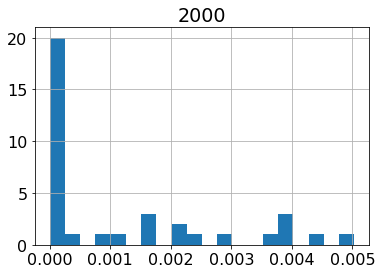

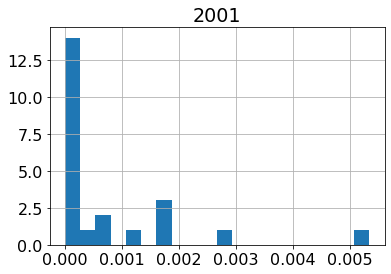

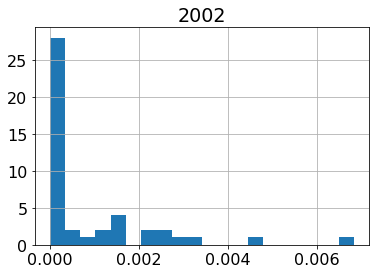

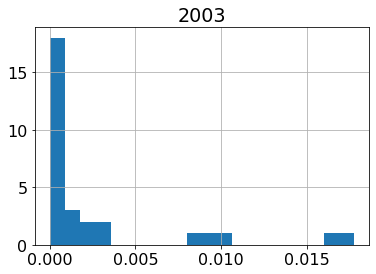

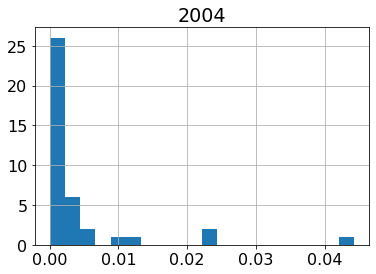

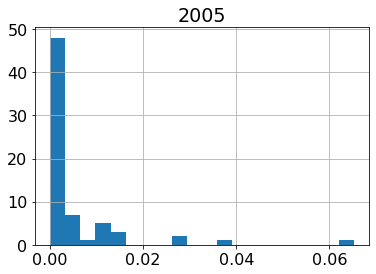

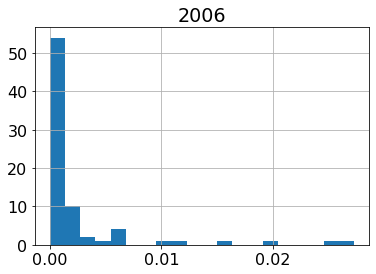

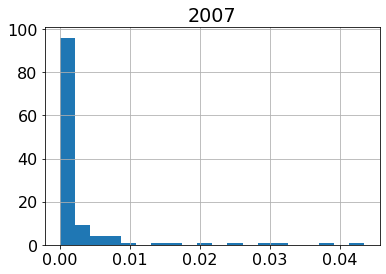

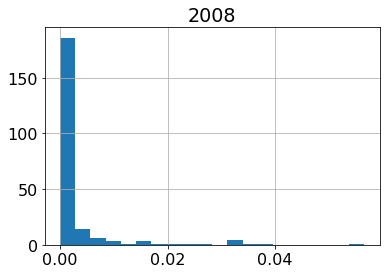

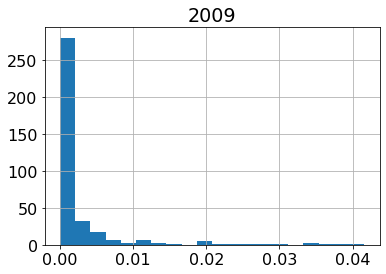

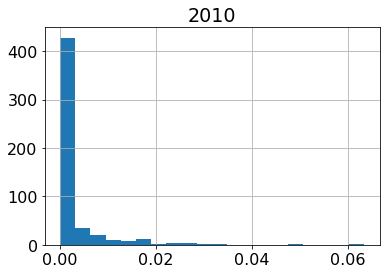

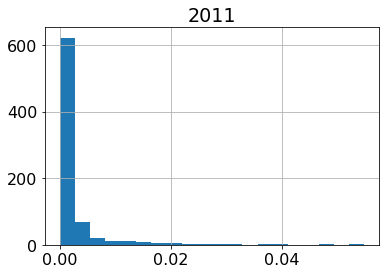

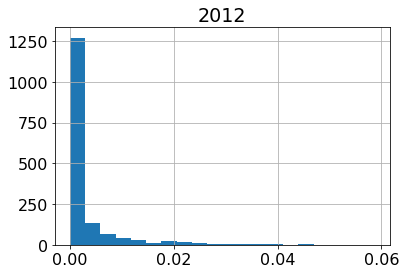

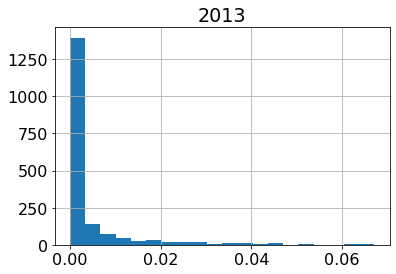

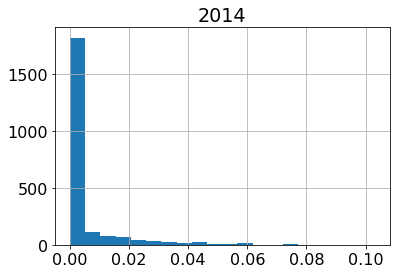

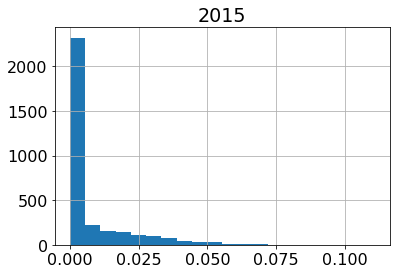

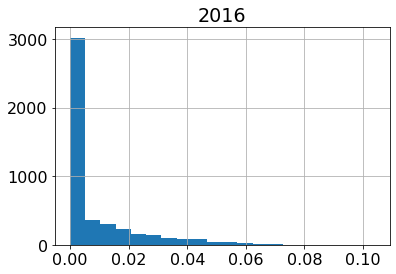

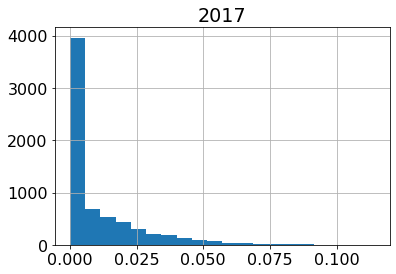

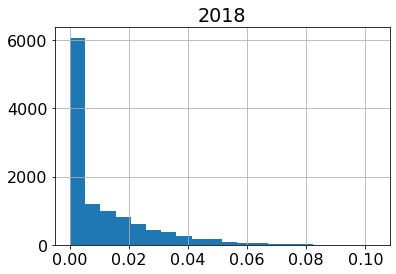

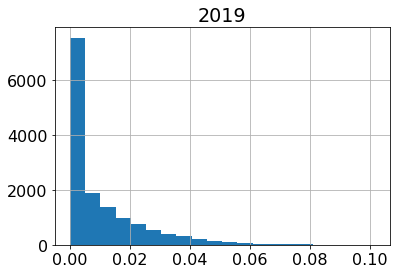

In [436]:
W_series = pd.Series(W[:, 2])
W_series.name = 'topic_loadings'
W_series = W_series.reset_index(drop=True)

for year in range(2000, 2020):
    W_series[years == str(year)].hist(bins=20)
    plt.title(str(year))
    plt.show()

## Topic 3 Over Time - "reinforcement learning"

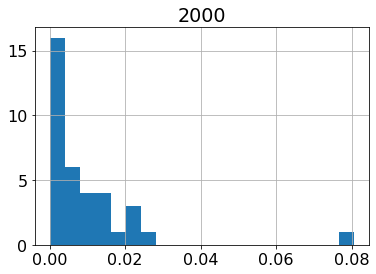

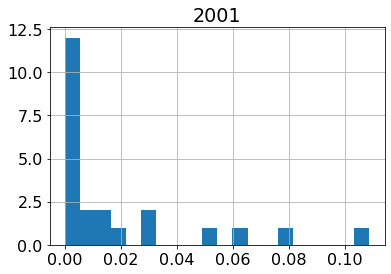

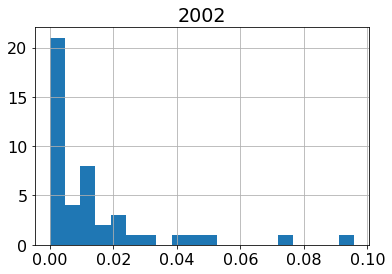

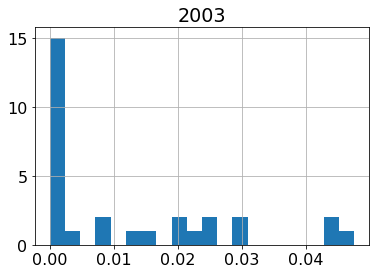

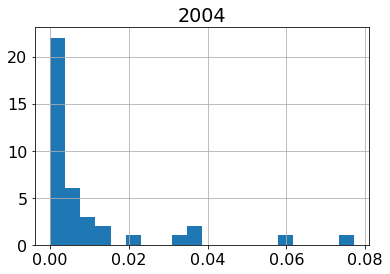

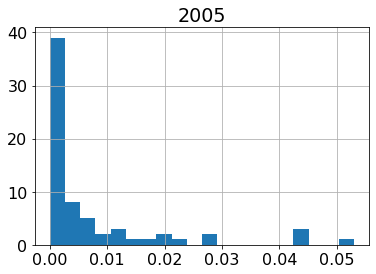

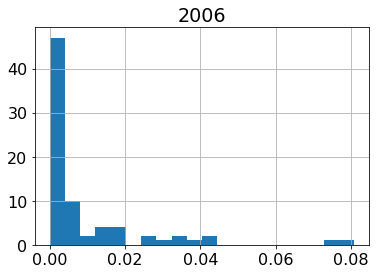

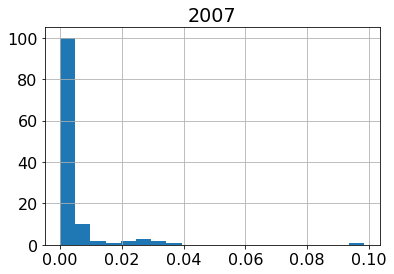

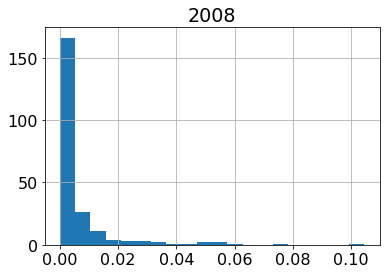

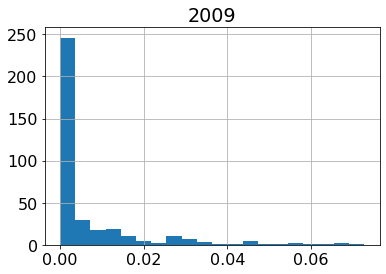

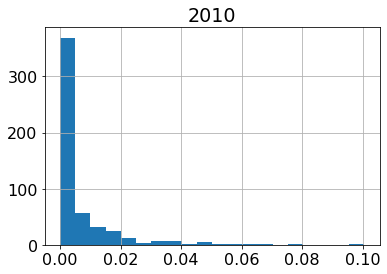

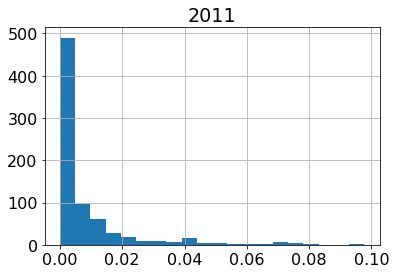

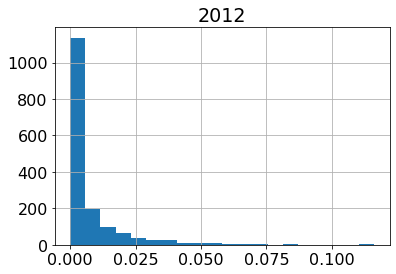

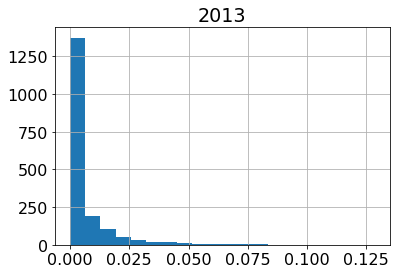

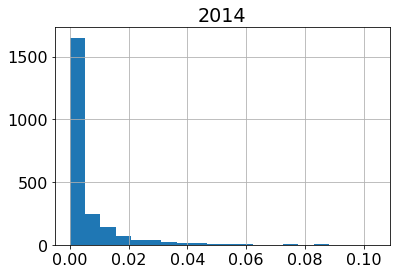

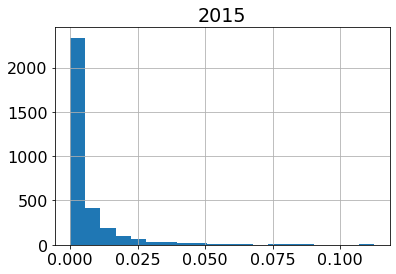

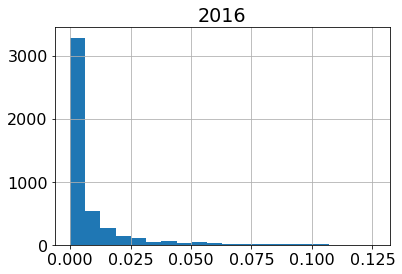

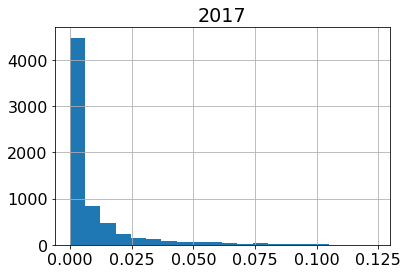

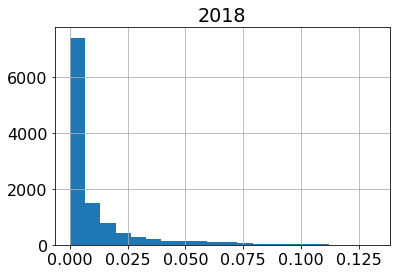

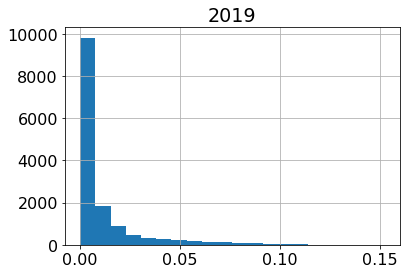

In [437]:
W_series = pd.Series(W[:, 3])
W_series.name = 'topic_loadings'
W_series = W_series.reset_index(drop=True)

for year in range(2000, 2020):
    W_series[years == str(year)].hist(bins=20)
    plt.title(str(year))
    plt.show()

## Topic 4 Over Time - "bayesian"

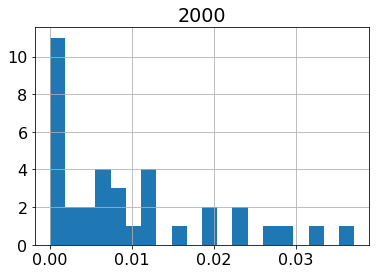

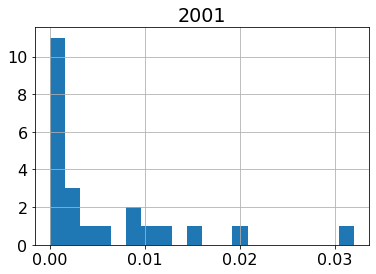

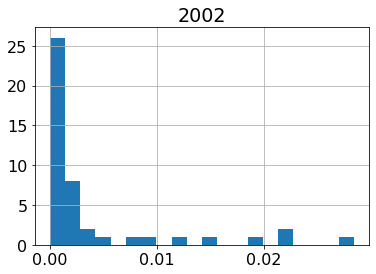

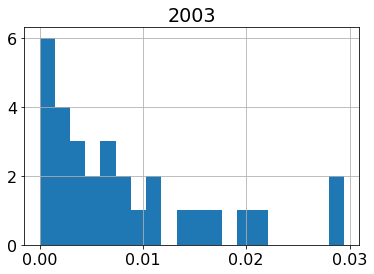

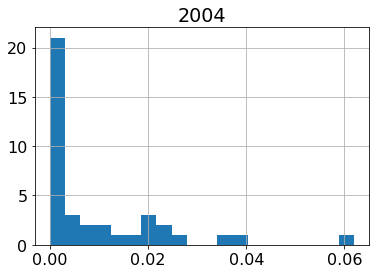

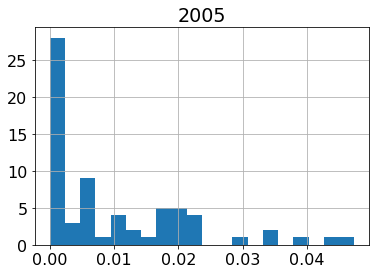

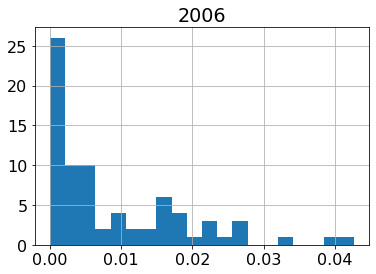

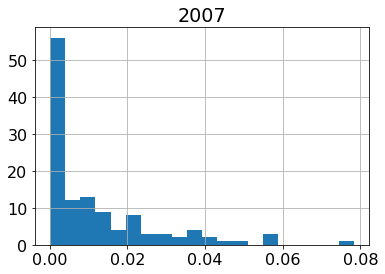

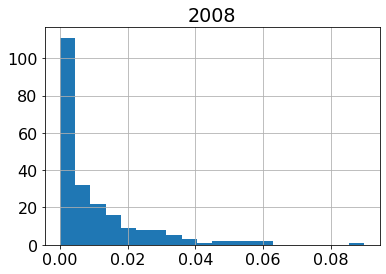

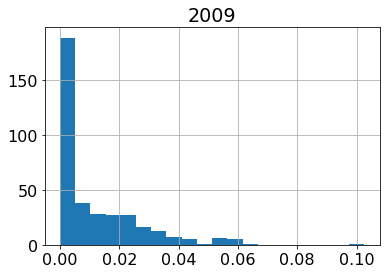

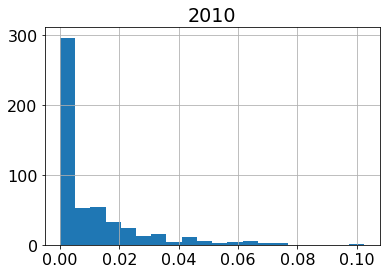

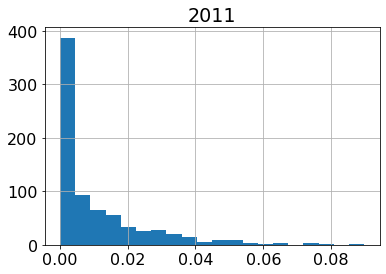

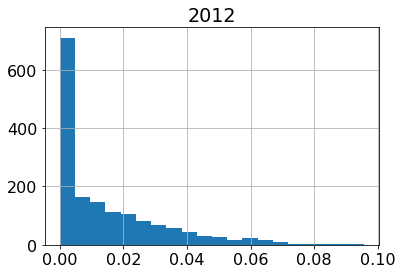

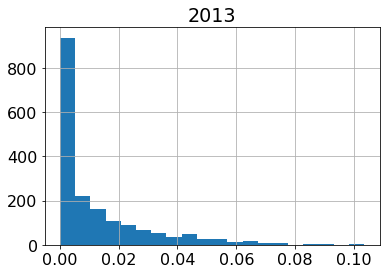

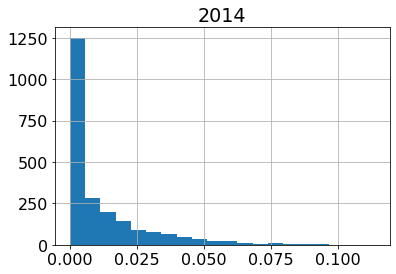

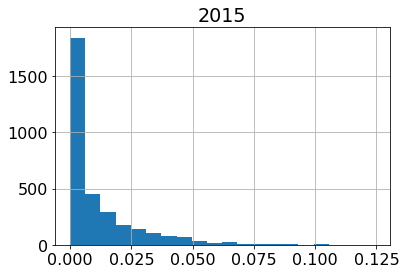

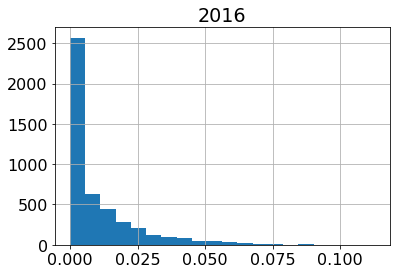

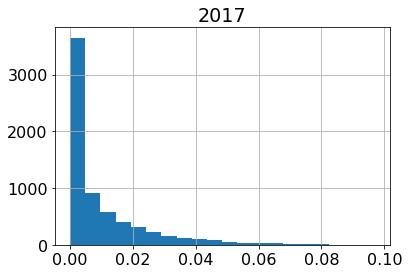

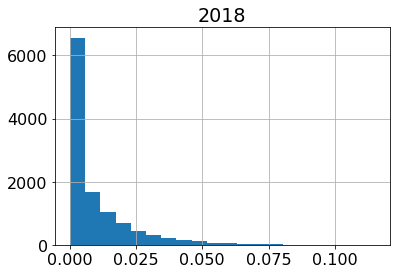

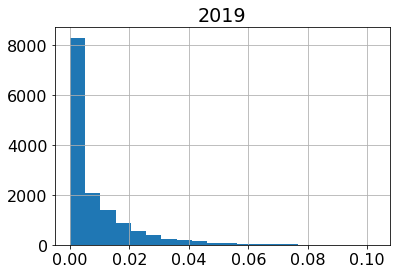

In [438]:
W_series = pd.Series(W[:, 4])
W_series.name = 'topic_loadings'
W_series = W_series.reset_index(drop=True)

for year in range(2000, 2020):
    W_series[years == str(year)].hist(bins=20)
    plt.title(str(year))
    plt.show()

## Topic 5 Over Time - "graphs / graph ML"

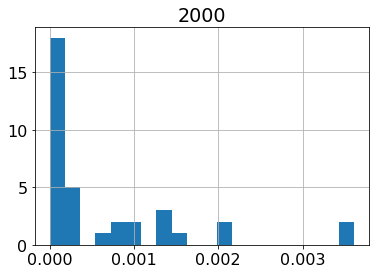

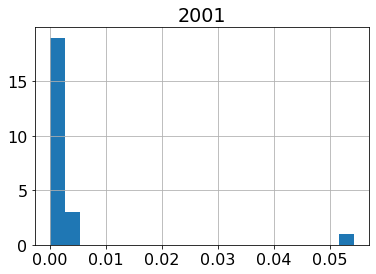

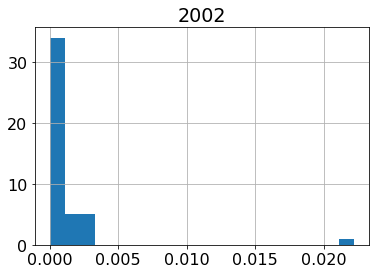

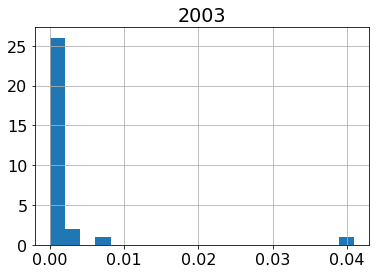

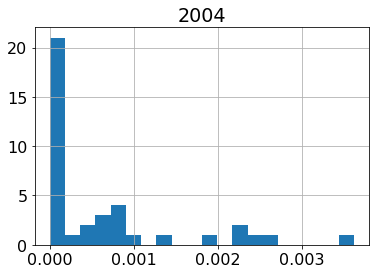

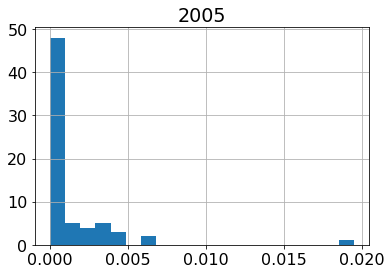

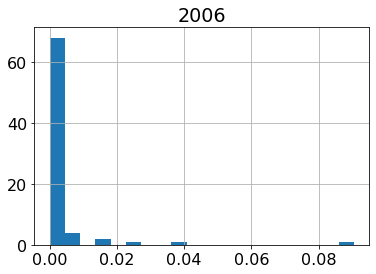

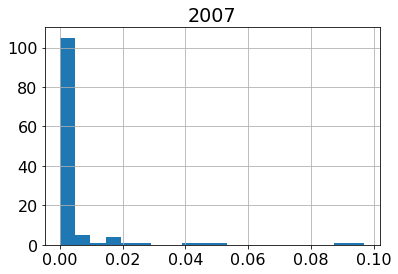

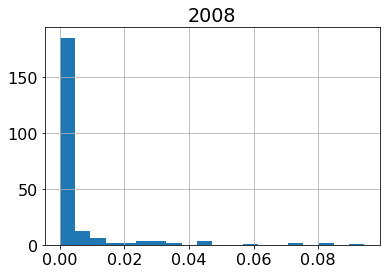

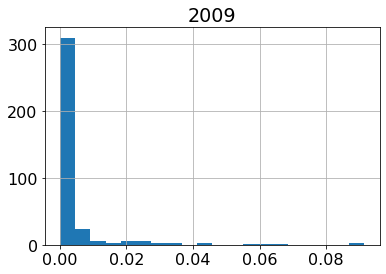

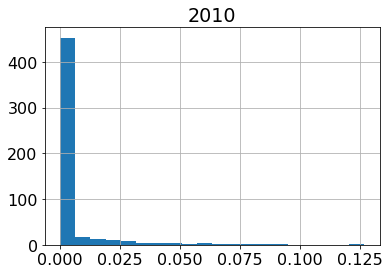

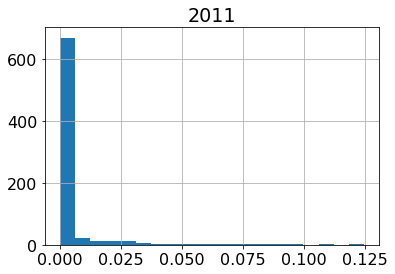

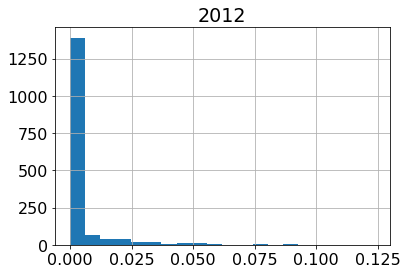

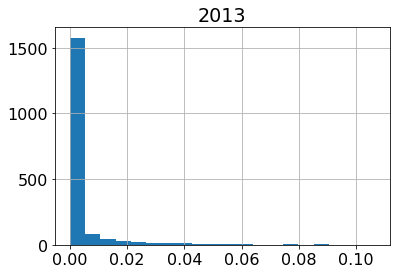

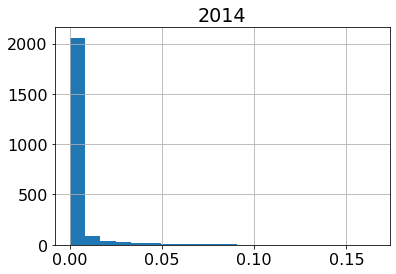

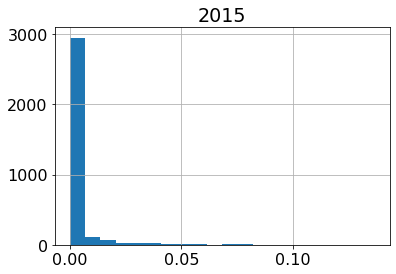

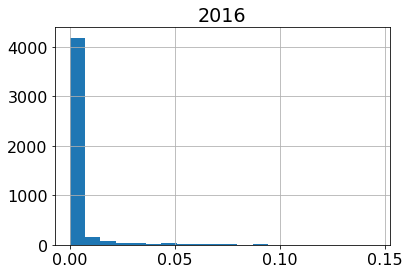

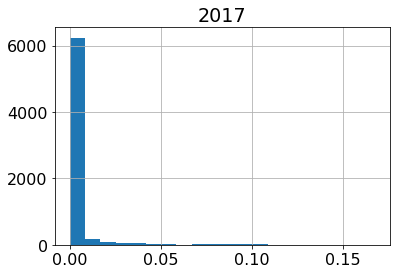

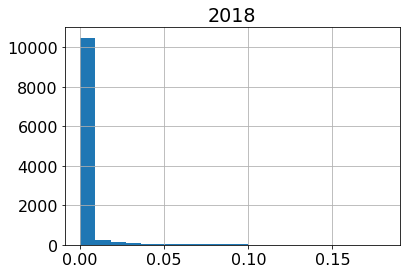

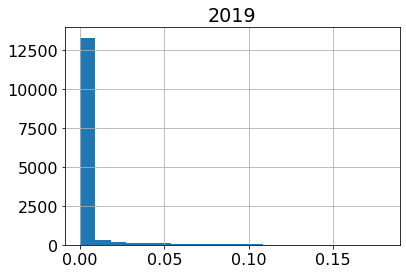

In [439]:
W_series = pd.Series(W[:, 5])
W_series.name = 'topic_loadings'
W_series = W_series.reset_index(drop=True)

for year in range(2000, 2020):
    W_series[years == str(year)].hist(bins=20)
    plt.title(str(year))
    plt.show()

## Topic 6 Over Time - "generative adversarial networks"

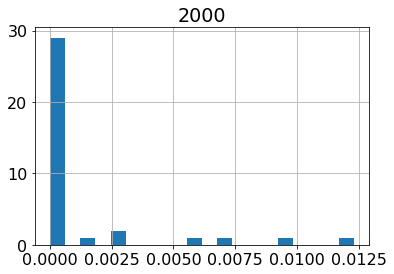

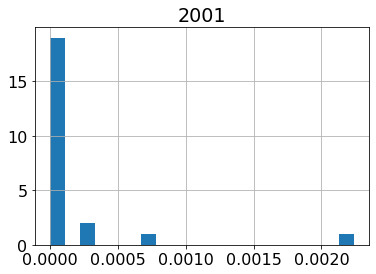

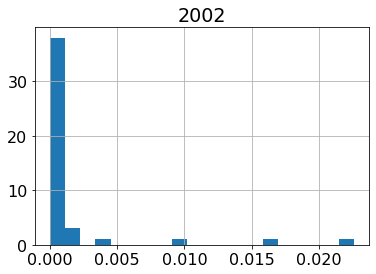

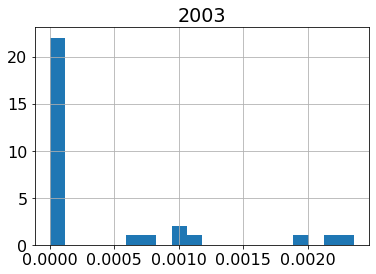

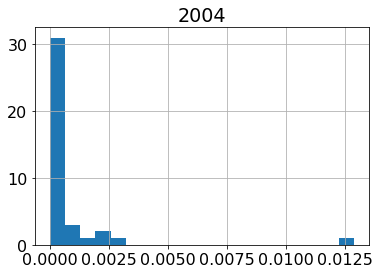

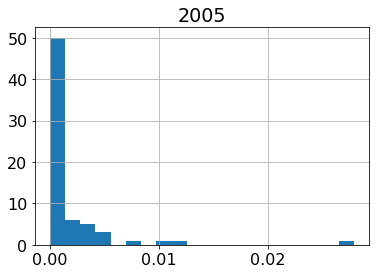

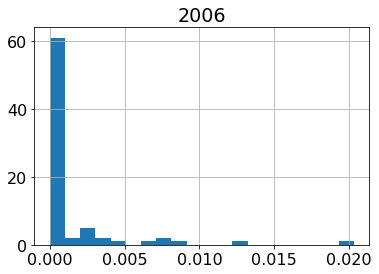

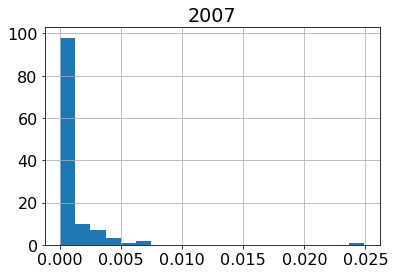

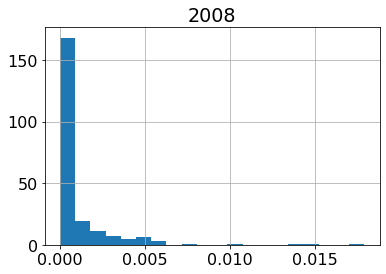

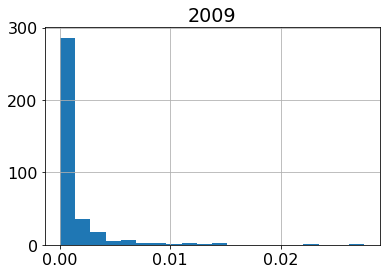

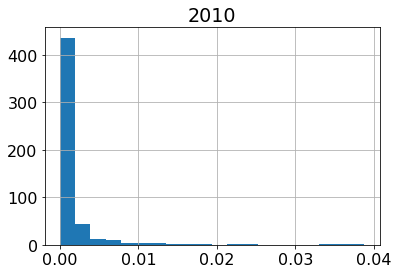

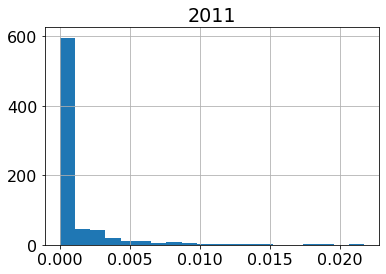

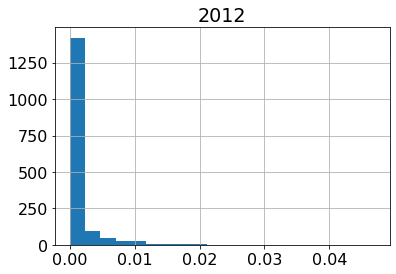

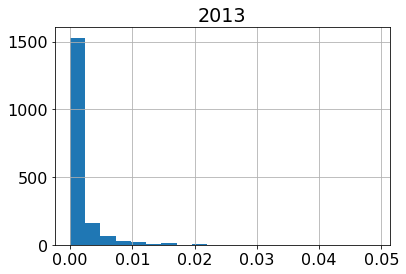

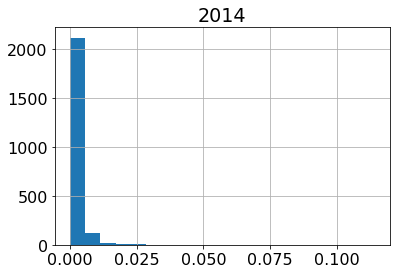

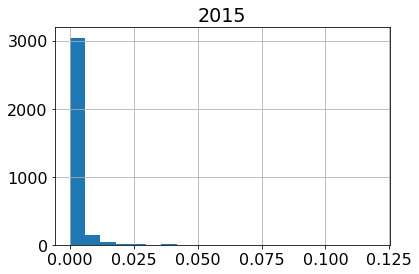

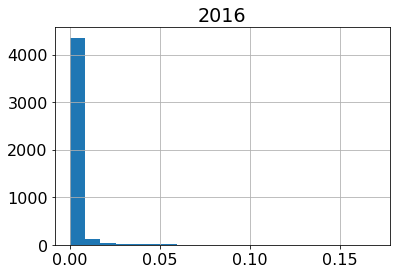

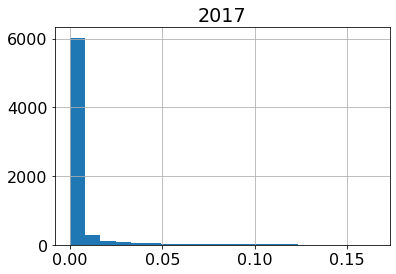

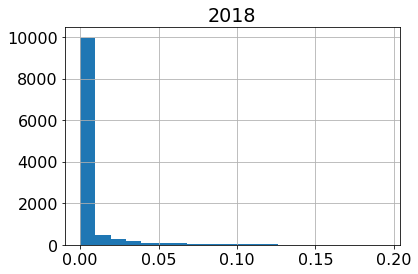

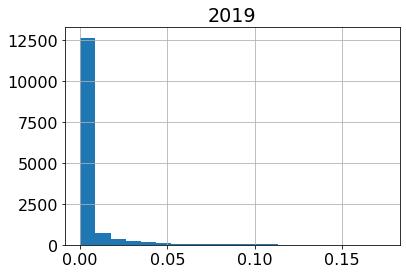

In [440]:
W_series = pd.Series(W[:, 6])
W_series.name = 'topic_loadings'
W_series = W_series.reset_index(drop=True)

for year in range(2000, 2020):
    W_series[years == str(year)].hist(bins=20)
    plt.title(str(year))
    plt.show()

## Topic 7 Over Time - "image classification"

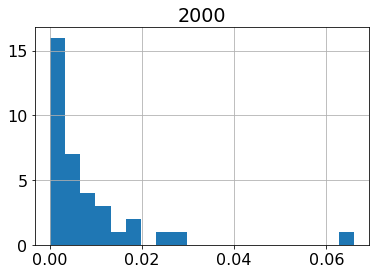

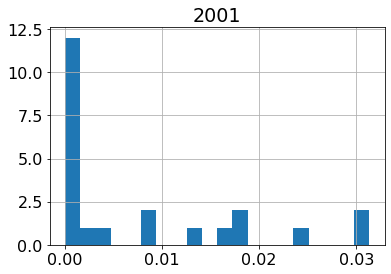

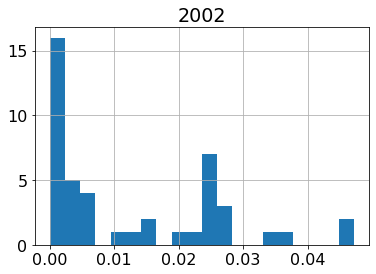

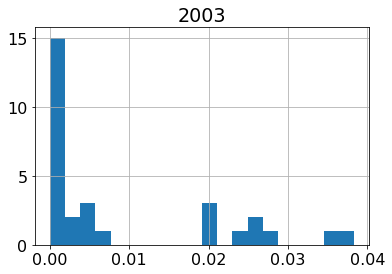

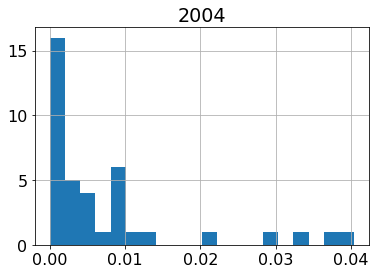

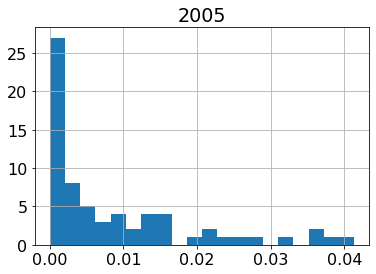

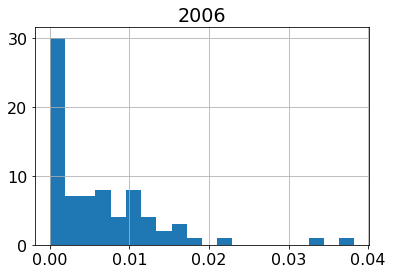

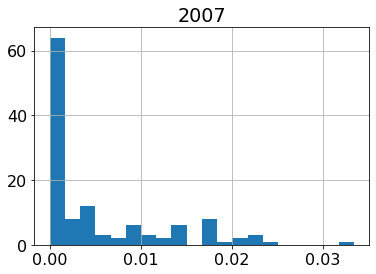

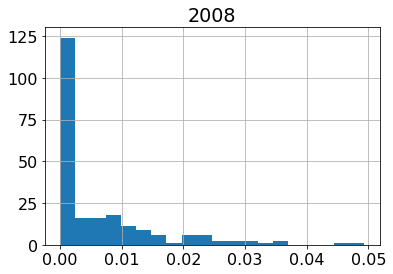

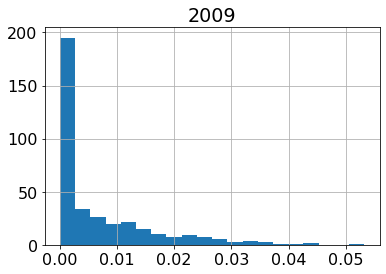

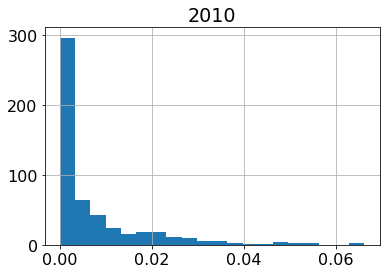

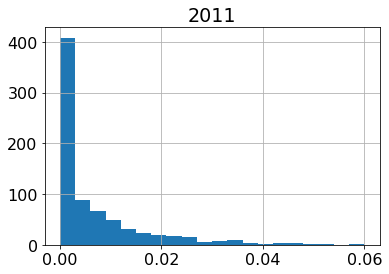

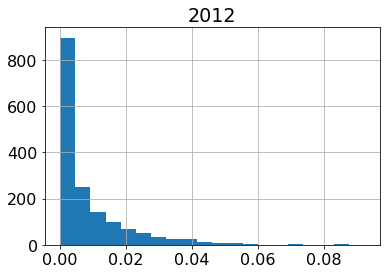

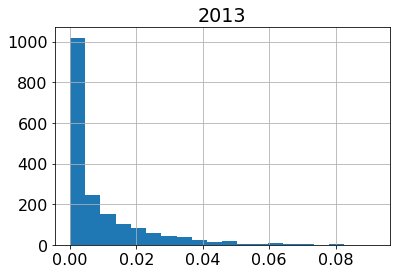

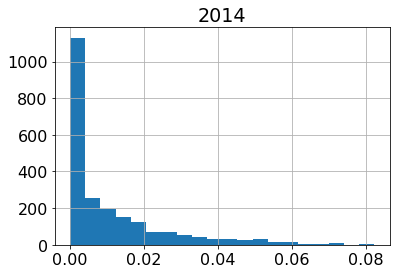

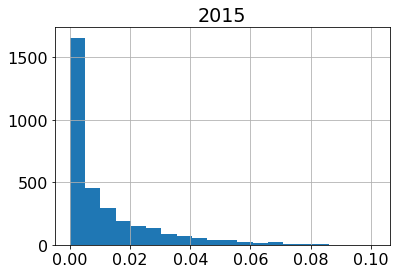

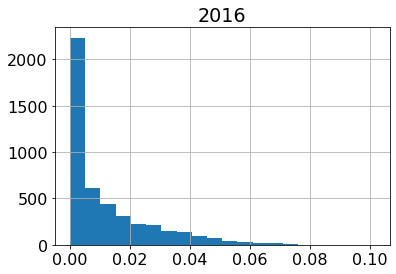

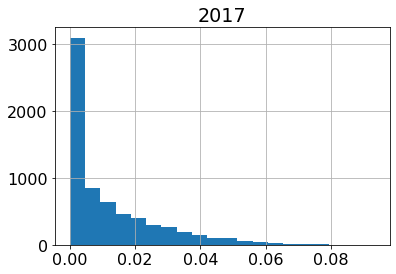

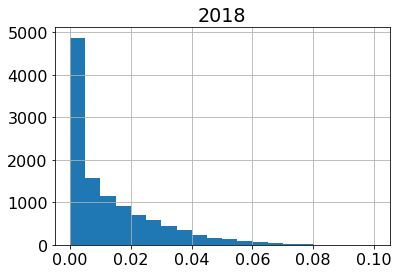

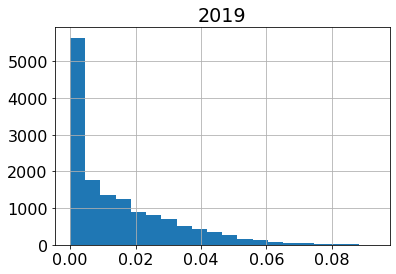

In [441]:
W_series = pd.Series(W[:, 7])
W_series.name = 'topic_loadings'
W_series = W_series.reset_index(drop=True)

for year in range(2000, 2020):
    W_series[years == str(year)].hist(bins=20)
    plt.title(str(year))
    plt.show()

## Topic 8 Over Time - "clustering"

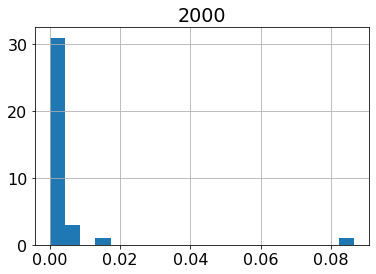

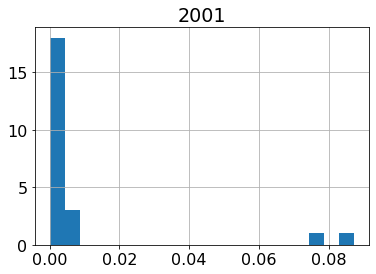

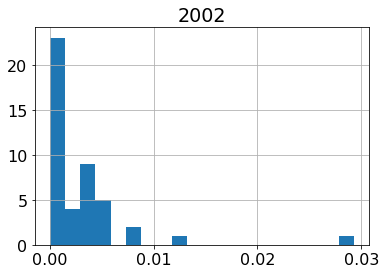

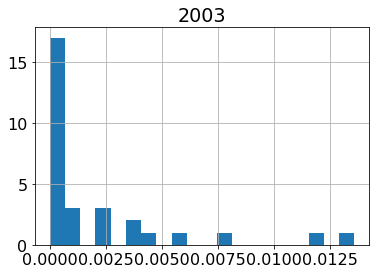

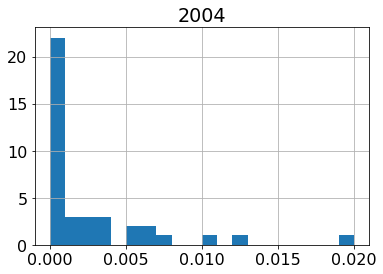

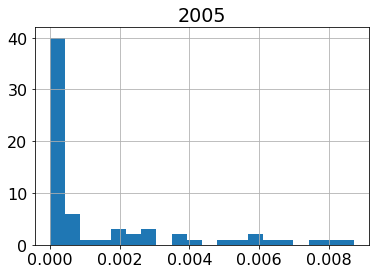

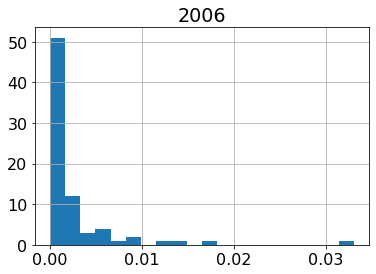

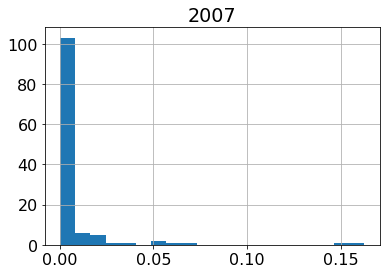

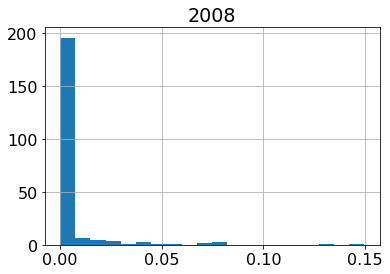

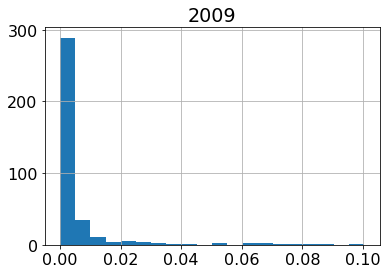

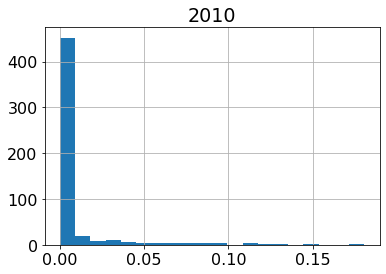

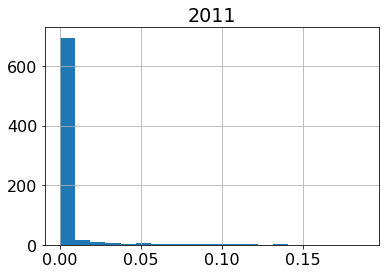

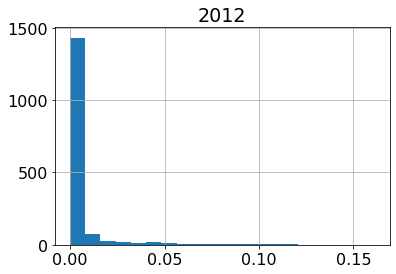

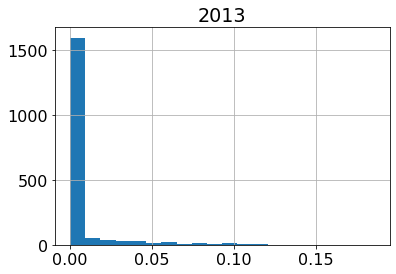

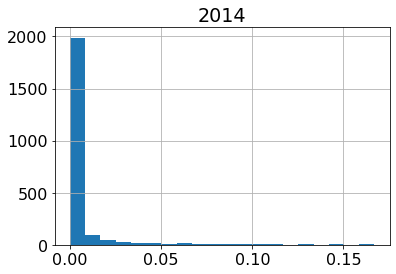

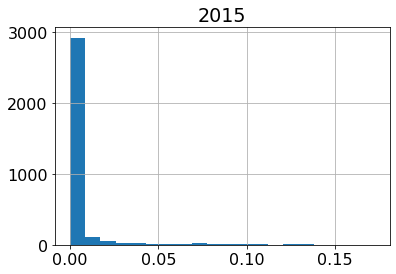

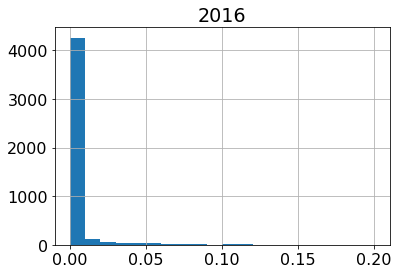

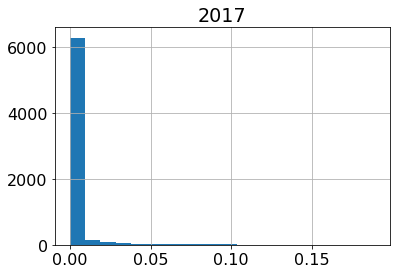

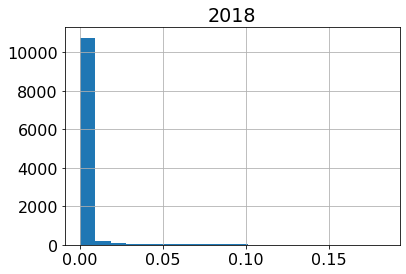

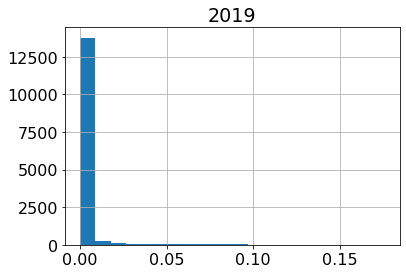

In [442]:
W_series = pd.Series(W[:, 8])
W_series.name = 'topic_loadings'
W_series = W_series.reset_index(drop=True)

for year in range(2000, 2020):
    W_series[years == str(year)].hist(bins=20)
    plt.title(str(year))
    plt.show()

## Topic 9 Over Time - "optimal solutions"

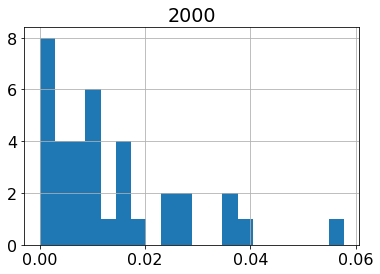

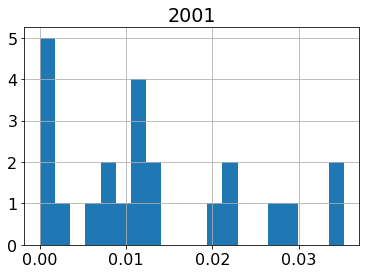

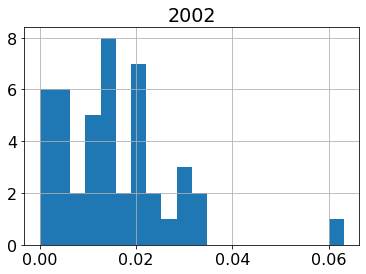

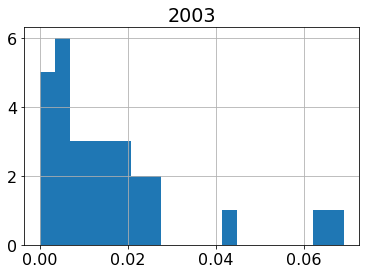

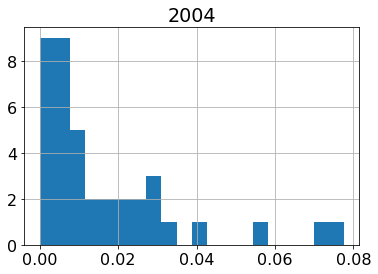

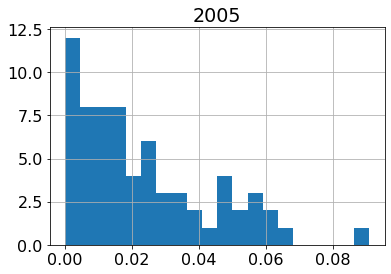

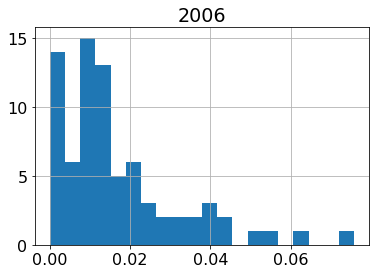

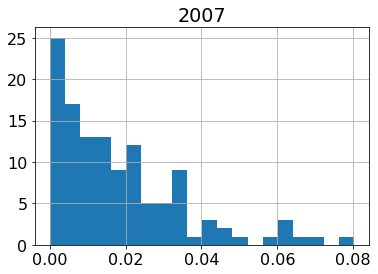

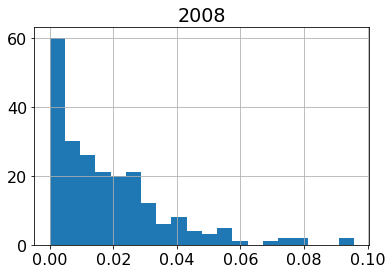

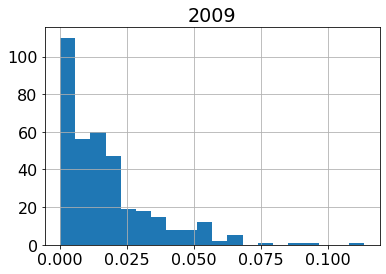

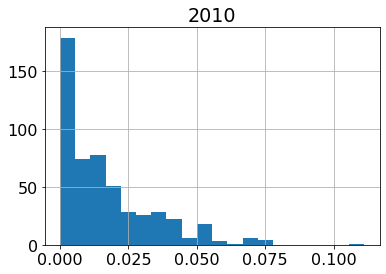

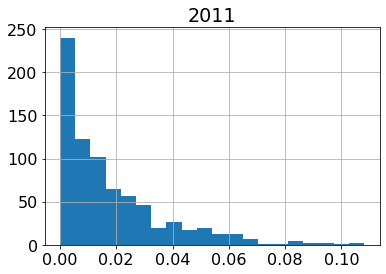

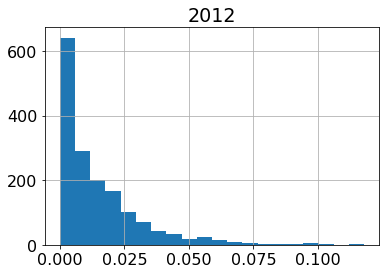

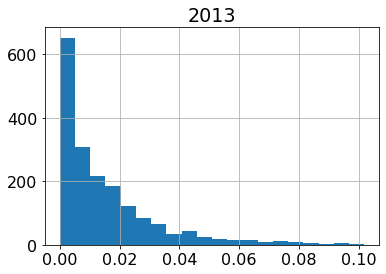

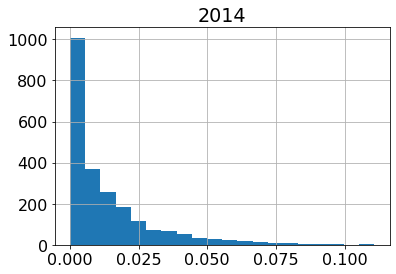

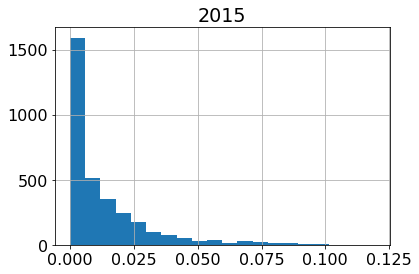

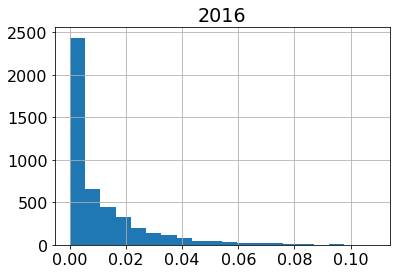

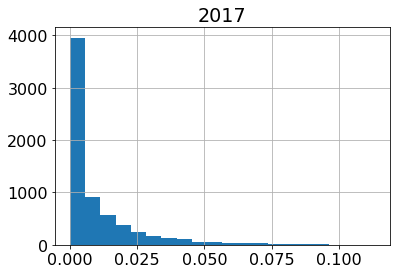

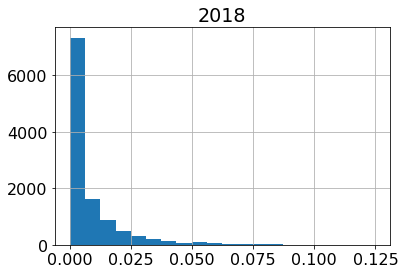

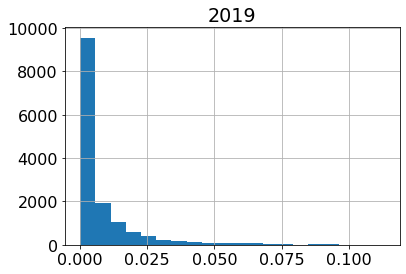

In [443]:
W_series = pd.Series(W[:, 9])
W_series.name = 'topic_loadings'
W_series = W_series.reset_index(drop=True)

for year in range(2000, 2020):
    W_series[years == str(year)].hist(bins=20)
    plt.title(str(year))
    plt.show()

# Look at paper descriptions and topic loadings

In [461]:
def softmax(v, temperature=1.0):
    '''
    A heuristic to convert arbitrary positive values into probabilities.
    See: https://en.wikipedia.org/wiki/Softmax_function
    '''
    expv = np.exp(v / temperature)
    s = np.sum(expv)
    return expv / s

def analyze_article(paper_idx, descriptions, titles, W, hand_labels):
    '''
    Print an analysis of a single NYT articles, including the article text
    and a summary of which topics it represents. The topics are identified
    via the hand-labels which were assigned by the user.
    '''
    print(titles[paper_idx])
    print(descriptions[paper_idx])
    probs = softmax(W[paper_idx], temperature=0.01)
    for prob, label in zip(probs, hand_labels):
        print('--> {:.2f}% {}'.format(prob * 100, label))
    print()

def analyze_random_article(descriptions, titles, W, hand_labels):
    paper_idx = np.random.randint(0, len(descriptions))
    print(paper_idx)
    analyze_article(paper_idx, descriptions.reset_index(drop=True), titles.reset_index(drop=True), W, hand_labels)

In [465]:
analyze_random_article(df_ml['description'], df_ml['title'], W, hand_labeled_features)

866
Agnostic Federated Learning
  A key learning scenario in large-scale applications is that of federated
learning, where a centralized model is trained based on data originating from a
large number of clients. We argue that, with the existing training and
inference, federated models can be biased towards different clients. Instead,
we propose a new framework of agnostic federated learning, where the
centralized model is optimized for any target distribution formed by a mixture
of the client distributions. We further show that this framework naturally
yields a notion of fairness. We present data-dependent Rademacher complexity
guarantees for learning with this objective, which guide the definition of an
algorithm for agnostic federated learning. We also give a fast stochastic
optimization algorithm for solving the corresponding optimization problem, for
which we prove convergence bounds, assuming a convex loss function and
hypothesis set. We further empirically demonstrate the benefit

# Let's identify the closest article to another article. Let's plug in 100% topic loadings for each topic and see what it returns, and then plug in combinations of topic loadings.
_(Note: Potentially another way to do the first step is to look at the documents that have max loadings on certain topics, although these documents might also have significant loadings on other topics (and thus not be pure in the desired topic).)_

In [491]:
doc_idx = 0
doc = W[doc_idx].reshape(1, -1)
all_other_docs = W[np.arange(len(W))!=0]
sims = cosine_similarity(doc, W)[0]
similar_doc_idxs = np.argsort(sims)[::-1]
similar_doc_idxs = similar_doc_idxs[similar_doc_idxs != doc_idx]
similar_doc_idxs
print('Original Paper:')
print()
print('*' * 50)
print('>>>', df_ml['title'].values[doc_idx])
print('*' * 50)
print()
print('Most Similar Papers:')
print()
for paper in df_ml['title'].values[similar_doc_idxs][:5]:
    print('>>>', paper)
    print()

In [480]:
all_other_docs = W[np.arange(len(W))!=0]

In [488]:
sims = cosine_similarity(doc, W)[0]

In [492]:
similar_doc_idxs = np.argsort(sims)[::-1]
similar_doc_idxs = similar_doc_idxs[similar_doc_idxs != doc_idx]
similar_doc_idxs

array([ 8176, 23181, 41323, ...,   147, 15624,  6327])

In [508]:
print('Original Paper:')
print()
print('*' * 50)
print('>>>', df_ml['title'].values[doc_idx])
print('*' * 50)
print()
print('Most Similar Papers:')
print()
for paper in df_ml['title'].values[similar_doc_idxs][:5]:
#    print('*' * 50)
    print('>>>', paper)
#    print('*' * 50)
    print()

Original Paper:

**************************************************
>>> A Unified SVM Framework for Signal Estimation
**************************************************

Most Similar Papers:

>>> Performance Analysis Of Regularized Linear Regression Models For
  Oxazolines And Oxazoles Derivitive Descriptor Dataset

>>> Solving Non-identifiable Latent Feature Models

>>> Structural modeling using overlapped group penalties for discovering
  predictive biomarkers for subgroup analysis

>>> Short-term time series prediction using Hilbert space embeddings of
  autoregressive processes

>>> Simultaneous Estimation of Non-Gaussian Components and their Correlation
  Structure



In [533]:
def get_closest_papers(doc_idx, W, df):
    doc = W[doc_idx].reshape(1, -1)
    sims = cosine_similarity(doc, W)[0]
    similar_doc_idxs = np.argsort(sims)[::-1]
    similar_doc_idxs = similar_doc_idxs[similar_doc_idxs != doc_idx]
    print('Original Paper:')
    print()
    print('*' * 50)
    print('>>>', df['title'].values[doc_idx])
    print('*' * 50)
    print()
    print('Most Similar Papers:')
    print()
    for paper in df['title'].values[similar_doc_idxs][:5]:
        print('>>>', paper)
        print()

def get_closest_papers_to_loading(loadings, W, df):
    sims = cosine_similarity(loadings, W)[0]
    similar_doc_idxs = np.argsort(sims)[::-1]
    print('Loadings:')
    print()
    print('*' * 50)
    print('>>>', loadings)
    print('*' * 50)
    print()
    print('Most Similar Papers:')
    print()
    for paper in df['title'].values[similar_doc_idxs][:5]:
        print('>>>', paper)
        print()

In [519]:
get_closest_papers(0, W, df_ml)

Original Paper:

**************************************************
>>> A Unified SVM Framework for Signal Estimation
**************************************************

Most Similar Papers:

>>> Performance Analysis Of Regularized Linear Regression Models For
  Oxazolines And Oxazoles Derivitive Descriptor Dataset

>>> Solving Non-identifiable Latent Feature Models

>>> Structural modeling using overlapped group penalties for discovering
  predictive biomarkers for subgroup analysis

>>> Short-term time series prediction using Hilbert space embeddings of
  autoregressive processes

>>> Simultaneous Estimation of Non-Gaussian Components and their Correlation
  Structure



In [520]:
get_closest_papers(1000, W, df_ml)

Original Paper:

**************************************************
>>> Evolving controllers for simulated car racing
**************************************************

Most Similar Papers:

>>> N2N Learning: Network to Network Compression via Policy Gradient
  Reinforcement Learning

>>> Neural Network Memory Architectures for Autonomous Robot Navigation

>>> Learning by Stimulation Avoidance: A Principle to Control Spiking Neural
  Networks Dynamics

>>> Efficient Architecture Search by Network Transformation

>>> Deep Recurrent Q-Learning vs Deep Q-Learning on a simple Partially
  Observable Markov Decision Process with Minecraft



In [526]:
for i in range(10):
    loadings = np.zeros(10).reshape(1, -1)
    loadings[0, i] = 1
    get_closest_papers_to_loading(loadings, W, df_ml)

Loadings:

**************************************************
>>> [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
**************************************************

Most Similar Papers:

>>> Conscientious Classification: A Data Scientist's Guide to
  Discrimination-Aware Classification

>>> Data Readiness Levels

>>> Preprocessing Methods and Pipelines of Data Mining: An Overview

>>> A streaming feature-based compression method for data from instrumented
  infrastructure

>>> Statistical Learning Theory Approach for Data Classification with
  l-diversity

Loadings:

**************************************************
>>> [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
**************************************************

Most Similar Papers:

>>> Accelerated Randomized Mirror Descent Algorithms For Composite
  Non-strongly Convex Optimization

>>> A geometric alternative to Nesterov's accelerated gradient descent

>>> Potential-Function Proofs for First-Order Methods

>>> MixedGrad: An O(1/T) Convergence Rate Algo

In [536]:
loadings = np.zeros(10).reshape(1, -1)
loadings[0, 5] = 1
loadings[0, 2] = 1
get_closest_papers_to_loading(loadings, W, df_ml)

Loadings:

**************************************************
>>> [[0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]]
**************************************************

Most Similar Papers:

>>> Learning Conserved Networks from Flows

>>> Factor Graph Neural Network

>>> Vertex Nomination Via Seeded Graph Matching

>>> Spectrum-based deep neural networks for fraud detection

>>> GraphNAS: Graph Neural Architecture Search with Reinforcement Learning



In [540]:
loadings = np.zeros(10).reshape(1, -1)
loadings[0, 3] = 1
loadings[0, 5] = 1
get_closest_papers_to_loading(loadings, W, df_ml)

Loadings:

**************************************************
>>> [[0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]]
**************************************************

Most Similar Papers:

>>> Graph Convolutional Reinforcement Learning

>>> Hierarchical Reinforcement Learning for Zero-shot Generalization with
  Subtask Dependencies

>>> RLgraph: Modular Computation Graphs for Deep Reinforcement Learning

>>> Learning Transferable Cooperative Behavior in Multi-Agent Teams

>>> The Laplacian in RL: Learning Representations with Efficient
  Approximations



In [542]:
loadings = np.zeros(10).reshape(1, -1)
loadings[0, 5] = 1
loadings[0, 7] = 1
get_closest_papers_to_loading(loadings, W, df_ml)

Loadings:

**************************************************
>>> [[0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]]
**************************************************

Most Similar Papers:

>>> Answering Visual-Relational Queries in Web-Extracted Knowledge Graphs

>>> Graph Convolutions over Constituent Trees for Syntax-Aware Semantic Role
  Labeling

>>> Context-Dependent Diffusion Network for Visual Relationship Detection

>>> Identifying Supporting Facts for Multi-hop Question Answering with
  Document Graph Networks

>>> Revisiting Semi-Supervised Learning with Graph Embeddings

